# Prédire la gravité d'un accident de la route

Le site data.gouv (a.k.a. l'open data public) met à disposition les bases de données annuelles des accidents corporels de la circulation routière. Chaque année, quatre bases sont publiées : usagers, véhicules, lieux et caractéristiques.

- [Accéder aux bases](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/)
- [Accéder à la documentation](https://www.data.gouv.fr/fr/datasets/r/8ef4c2a3-91a0-4d98-ae3a-989bde87b62a)

L'objectif est de prédire la gravité d'un accident en fonction de ses autres caractéristiques. La variable gravité est présente dans la base usagers. Elle peut prendre les valeurs suivantes (code dans la base entre parenthèses) : indemne (1), tué (2), blessé hospitalisé (3) et blessé léger (4).

_Note : nous avons recodé la variable par ordre de gravité pour obtenir des résultats intermédiaires et finaux plus intuitifs. Cela donne : indemne (1), blessé léger (2), blessé hospitalisé (3), tué (4)._

## Structure

Ce notebook suit la structure suivante.
1. Import et nettoyage des données
2. EDA (analyse exploratoire)
3. Modélisation

On charge dans un premier temps tous les packages nécessaires.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import et nettoyage des données

Nous avons choisi de charger les bases existantes sur les quatre dernières années, de 2019 à 2022.

In [2]:
df_usagers_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/62c20524-d442-46f5-bfd8-982c59763ec8", sep=";")
df_vehicules_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/c9742921-4427-41e5-81bc-f13af8bc31a0", sep=";")
df_lieux_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a6ef711a-1f03-44cb-921a-0ce8ec975995", sep=";")
df_caracs_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/5fc299c0-4598-4c29-b74c-6a67b0cc27e7", sep=";")

df_usagers_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/ba5a1956-7e82-41b7-a602-89d7dd484d7a", sep=";")
df_vehicules_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0bb5953a-25d8-46f8-8c25-b5c2f5ba905e", sep=";")
df_lieux_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/8a4935aa-38cd-43af-bf10-0209d6d17434", sep=";")
df_caracs_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/85cfdc0c-23e4-4674-9bcd-79a970d7269b", sep=";")

df_usagers_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/78c45763-d170-4d51-a881-e3147802d7ee", sep=";")
df_vehicules_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a66be22f-c346-49af-b196-71df24702250", sep=";")
df_lieux_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/e85c41f7-d4ea-4faf-877f-ab69a620ce21", sep=";")
df_caracs_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/07a88205-83c1-4123-a993-cba5331e8ae0", sep=";")

df_usagers_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/36b1b7b3-84b4-4901-9163-59ae8a9e3028", sep=";")
df_vehicules_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/780cd335-5048-4bd6-a841-105b44eb2667", sep=";")
df_lieux_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/2ad65965-36a1-4452-9c08-61a6c874e3e6", sep=";")
df_caracs_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/e22ba475-45a3-46ac-a0f7-9ca9ed1e283a", sep=";")

c:\Users\nahta\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


On importe également un module codé par nos soins et qui permet un premier nettoyage les données une première fois. Il s'agit essentiellement de recoder les modalités de variables qui sont peu éloquentes (codées par des nombres) pour les transformer en chaînes de caractères, plus parlantes pour l'analyse exploratoire.

Ce module, `data_cleaning`, comporte quatre fonctions qui permettent de nettoyer ainsi les quatre type de bases :
- `clean_df_usagers`,
- `clean_df_vehicules`,
- `clean_df_lieux`,
- `clean_df_caracs`.

In [3]:
from data_cleaning import *

On fait passer tous les dataframes par le nettoyage.

In [4]:
df_usagers_22 = clean_df_usagers(df_usagers_22)
df_vehicules_22 = clean_df_vehicules(df_vehicules_22)
df_lieux_22 = clean_df_lieux(df_lieux_22)
df_caracs_22 = clean_df_caracs(df_caracs_22)

df_usagers_21 = clean_df_usagers(df_usagers_21)
df_vehicules_21 = clean_df_vehicules(df_vehicules_21)
df_lieux_21 = clean_df_lieux(df_lieux_21)
df_caracs_21 = clean_df_caracs(df_caracs_21)

df_usagers_20 = clean_df_usagers(df_usagers_20)
df_vehicules_20 = clean_df_vehicules(df_vehicules_20)
df_lieux_20 = clean_df_lieux(df_lieux_20)
df_caracs_20 = clean_df_caracs(df_caracs_20)

df_usagers_19 = clean_df_usagers(df_usagers_19)
df_vehicules_19 = clean_df_vehicules(df_vehicules_19)
df_lieux_19 = clean_df_lieux(df_lieux_19)
df_caracs_19 = clean_df_caracs(df_caracs_19)

## Jointure

À présent, nous effectuons une jointure pour obtenir une unique base avec une ligne par victime (la base usagers est le dénominateur commun : on peut avoir plusieurs victimes pour un même véhicule, plusieurs victimes pour un même lieu ou pour un même accident).

Nous réalisons la jointure pour l'année 2022 par étapes pour bien expliquer le fonctionnement.

On s'assure qu'on a bien autant d'observations dont le triplet `(Num_Acc, id_vehicule, num_veh)` est unique dans les bases `usagers` et `véhicules`.

In [5]:
(~df_usagers_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

In [6]:
(~df_usagers_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

In [7]:
(~df_vehicules_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

À présent, on peut procéder à la jointure à l'aide de `pd.merge`. On joint d'abord les bases `usagers` et `vehicules` sur `(Num_Acc, id_vehicule, num_veh)`, puis on joint également les bases `lieux` et `caracs` sur l'identifiant de l'accident, codé par `Num_Acc`.

In [8]:
df_merged_22 = pd.merge(pd.merge(pd.merge(df_usagers_22, df_vehicules_22, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_22, on="Num_Acc"), df_caracs_22, on="Num_Acc")

On retombe bien ci-dessous sur un total de 126 662 observations, soit la longueur de la base usagers.

In [9]:
len(df_merged_22)

126662

On fait de même pour les autres années.

In [10]:
df_merged_21 = pd.merge(pd.merge(pd.merge(df_usagers_21, df_vehicules_21, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_21, on="Num_Acc"), df_caracs_21, on="Num_Acc")

df_merged_20 = pd.merge(pd.merge(pd.merge(df_usagers_20, df_vehicules_20, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_20, on="Num_Acc"), df_caracs_20, on="Num_Acc")

df_merged_19 = pd.merge(pd.merge(pd.merge(df_usagers_19, df_vehicules_19, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_19, on="Num_Acc"), df_caracs_19, on="Num_Acc")

On concatène le tout pour obtenir une base unifiée.

In [11]:
df_merged = pd.concat([df_merged_22, df_merged_21, df_merged_20, df_merged_19], ignore_index=True)

In [12]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494182 entries, 0 to 494181
Data columns (total 56 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      494182 non-null  int64  
 1   id_usager    255910 non-null  object 
 2   id_vehicule  494182 non-null  object 
 3   num_veh      494182 non-null  object 
 4   place        494157 non-null  float64
 5   catu         494182 non-null  object 
 6   grav         493881 non-null  float64
 7   sexe         488376 non-null  object 
 8   an_nais      488241 non-null  float64
 9   trajet       360809 non-null  object 
 10  secu1        388294 non-null  object 
 11  secu2        59943 non-null   object 
 12  secu3        4029 non-null    object 
 13  locp         277429 non-null  float64
 14  actp         222449 non-null  object 
 15  etatp        37936 non-null   object 
 16  senc         492526 non-null  float64
 17  catv         493108 non-null  float64
 18  obs          493991 non-

## Nettoyages

### Nettoyage de variables

Comme annoncé dans l'introduction, nous avons recodons la variable `grav` par ordre de gravité pour obtenir des résultats intermédiaires et finaux plus intuitifs. Cela donne :
- indemne (1), 
- blessé léger (2), 
- blessé hospitalisé (3), 
- tué (4).

In [13]:
df_merged["grav"].replace({2: 4, 4: 2}, inplace=True)

`vma` indique la vitesse maximale autorisée sur la voie empruntée. Les vitesses supérieures à 130 sont donc des erreurs. Puisqu'il n'existe aucune autre base recensant les vitesses (ce qui permettrait d'imputer les bonnes valeurs à l'aide d'une jointure), on les remplace par des `NaN`.

Les valeurs très faibles comme 1 sont suspectes, mais dans le doute il est préférable de les conserver.

In [14]:
df_merged.loc[df_merged['vma'] > 130, 'vma'] = np.nan

On met la variable `heure` au format approprié.

In [15]:
df_merged['heure'] = pd.to_datetime(df_merged['hrmn'], format='%H:%M').dt.time

Les variables `lat` et `long` étaient codées selon les normes typographiques françaises (virgules au lieu des points pour les nombres décimaux) et donc non reconnues par Python comme des nombres. On les transforme en float.

In [16]:
df_merged['lat'] = df_merged['lat'].str.replace(',', '.').astype(float)
df_merged['long'] = df_merged['long'].str.replace(',', '.').astype(float)

On élimine les observations dont l'année de naissance de la victime est strictement inférieure à 1920. Au mieux il y en a très peu, au pire cela contient des valeurs aberrantes (une victime née en 1900, cela paraît assez peu plausible...).

In [17]:
df_merged = df_merged[df_merged["an_nais"] >= 1920]

On élimine l'unique `NaN` de la variable `grav`.

In [18]:
df_merged.dropna(subset=['grav'], inplace=True)

### Suppression de variables

On élimine d'emblée certaines variables qui ne serviront pas au modèle de prédiction de la gravité.

In [19]:
df_merged.drop(["Num_Acc", "id_usager", "id_vehicule", "num_veh", "voie", "v1", "v2",
                "dep", "com", "adr", "lat", "long", "pr", "pr1", "an"], axis=1, inplace=True)

On peut également enlever `lartpc` et `occutc` qui ont trop de `NaN`.

In [20]:
df_merged.drop(["lartpc", "occutc"], axis=1, inplace=True)

### Ajout de variables

On crée une variable `h` (pour heure), plus pratique par la suite pour certains plots.

In [21]:
df_merged["h"] = df_merged["heure"]. apply(lambda x: x.hour)

On crée une nouvelle variable de type booléen pour chaque équipement de sécurité (au lieu d'avoir trois colonnes recensant les équipements).

Note : pour la modalité peu claire `gants + airbag`, on fait comme si cela signifiait qu'à la fois les gants et l'airbag étaient présents.

In [22]:
for equipement in ["ceinture", "casque", "dispositif enfants", "gilet réfléchissant",
                   "airbag", "gants", "gants + airbag", "autre"]:
    df_merged[equipement] = df_merged[["secu1", "secu2", "secu3"]].isin([equipement]).any(axis=1)

df_merged["airbag"] = df_merged["airbag"] | df_merged["gants + airbag"]
df_merged["gants"] = df_merged["gants"] | df_merged["gants + airbag"]
df_merged.drop("gants + airbag", axis=1, inplace=True)

### Général

On convertit les valeurs `-1` en `np.NaN`.

In [23]:
df_merged.replace(-1, np.nan, inplace=True)
df_merged.replace("-1", np.nan, inplace=True)
df_merged.replace(" -1", np.nan, inplace=True)

Voici les colonnes finales qui composent le dataframe.

In [24]:
df_merged.columns

Index(['place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2',
       'secu3', 'locp', 'actp', 'etatp', 'senc', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'catv_2', 'catr', 'circ', 'nbv', 'vosp', 'prof',
       'plan', 'larrout', 'surf', 'infra', 'situ', 'vma', 'jour', 'mois',
       'hrmn', 'lum', 'agg', 'int', 'atm', 'col', 'heure', 'h', 'ceinture',
       'casque', 'dispositif enfants', 'gilet réfléchissant', 'airbag',
       'gants', 'autre'],
      dtype='object')

Brève description des variables
- `place` : place occupée dans le véhicule par l'usager au moment de l'accident ; 1 conducteur, 10 piéton
- `sexe` : sexe de l'usager
- `an_nais` : année de naissance de l'usager
- `trajet` : motif du déplacement au moment de l'accident
- `secu` : présence et utilisation de tel équipement de sécurité
- `locp` : localisation du piéton
- `actp` : action du piéton
- `etatp` : piéton seul, accompagné ou en groupe
- `senc` : sens de circulation
- `catv` : catégorie du véhicule
- `obs` : obstacle fixe heurté
- `obsm` : obstacle mobile heurté
- `choc` : point de choc initial
- `manv` : manoeuvre principale avant l'accident 
- `motor` : type de motoristion du véhicule
- `catr` : catégorie de route
- `circ` : régime de circulation
- `nbv` : nombre de voies
- `vosp` : existence d'une voie réservée (que l'accident ait eu lieu ou non sur cette voie)
- `prof` : décrit la déclivité de la route à l'endroit de l'accident
- `larrout` : largeur de la chaussée (hors bande d'arrêt d'urgence, TPC et places de stationnement)
- `surf` : état de la surface
- `infra` : infrastructure/amménagement (exemples : souterrain, voie ferrée)
- `situ` : situation de l'accident (exemples : sur la chaussée, sur le trottoir)
- `vma` : vitesse maximale autorisée sur le lieu et au moment de l'accident
- `jour` : jour de l'accident
- `mois` : mois de l'accident 
- `hrmn` : heure et minute de l'accident 
- `lum` : lumière/condition d'éclairage 
- `agg` : localisation (hors agglomération ou en agglomération)
- `int` : type d'intersection
- `atm` : conditions atmosphériques 
- `col` : type de collision

# EDA (analyse exploratoire)

In [25]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488036 entries, 0 to 494181
Data columns (total 48 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   place                488036 non-null  float64
 1   catu                 488036 non-null  object 
 2   grav                 488036 non-null  float64
 3   sexe                 488032 non-null  object 
 4   an_nais              488036 non-null  float64
 5   trajet               360697 non-null  object 
 6   secu1                388117 non-null  object 
 7   secu2                59926 non-null   object 
 8   secu3                4024 non-null    object 
 9   locp                 276855 non-null  float64
 10  actp                 36767 non-null   object 
 11  etatp                37921 non-null   object 
 12  senc                 486435 non-null  float64
 13  catv                 487369 non-null  float64
 14  obs                  487881 non-null  float64
 15  obsm             

In [26]:
df_merged.columns

Index(['place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2',
       'secu3', 'locp', 'actp', 'etatp', 'senc', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'catv_2', 'catr', 'circ', 'nbv', 'vosp', 'prof',
       'plan', 'larrout', 'surf', 'infra', 'situ', 'vma', 'jour', 'mois',
       'hrmn', 'lum', 'agg', 'int', 'atm', 'col', 'heure', 'h', 'ceinture',
       'casque', 'dispositif enfants', 'gilet réfléchissant', 'airbag',
       'gants', 'autre'],
      dtype='object')

On créé deux nouveaux dataframe à partir de notre dataframe principal :
- `df_non_pieton`, sous-dataframe constitué uniquement des observations dont la victime est conducteur ou passager ;
- `df_pieton`, sous-dataframe consitué uniquement des observations dont la victime est piéton.

On les utilisera pour étudier certaines variables qui ne sont pertinentes que pour un certain type d'usagers (ex : `actp` (action du piéton)).

In [27]:
df_non_pieton = df_merged[df_merged["catu"]!="piéton"]
df_pieton = df_merged[df_merged["catu"]=="piéton"]

## Variable `grav`

Avant tout, enquérissons-nous de la proportion de chaque degré de gravité dans la base de données. On affiche pour cela un diagramme circulaire.

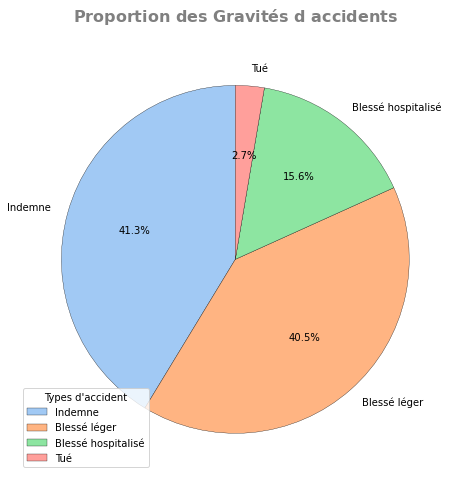

In [28]:
accident_counts = df_merged['grav'].value_counts()
labels_pie_chart = {1: 'Indemne', 2: 'Blessé léger', 3: 'Blessé hospitalisé', 4: 'Tué'}
accident_counts.index = accident_counts.index.map(labels_pie_chart)
colors = sns.color_palette('pastel')  
plt.figure(figsize=(8, 8))
plt.pie(accident_counts, labels=accident_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=1, edgecolor='black', linewidth=0.3)) # dict(width=1)
plt.title(r'$\bf{ Proportion\ des\ Gravités\ d\ accidents}$', fontsize=16, loc='center', pad=20, color='grey')
plt.legend(title='Types d\'accident', loc='lower left', bbox_to_anchor=(0.0005, 0.01))
plt.show() 

La part d'accidents graves (de type 3 ou 4) est bien plus faible que celle des accidents légers (de type 1 ou 2). On a donc beaucoup moins d'observations d'accidents mortels. Cela peut affecter la qualité de prédiction de nos modèles pour ce type d'accidents, comme on le verra dans la section _Modélisation_.

## Exploration des variables selon `grav`

À présent, l'idée est de chercher quelles sont les variables qui discriminent le mieux la gravité. En d'autres termes, on regarde pour une variable donnée si la proportion des degrés de gravité est la même ou non pour toutes les modalité. (La quasi-totalité des variables des bases sont catégorielles. Pour les quelques variables continues : âge, vitesse maximal et heure, on discrétise pour obtenir des insights similaires.)

Bien sûr, on préfère les variables dont les modalités ont des "profils de gravité" différents, car cela signifie qu'elles sont utiles pour prédire la gravité d'un accident. Au contraire, toutes les modalités d'une même variable ont des proportions de gravité similaires, la variable n'aidera pas à prédire la gravité...

Pour chaque variable, on trace essentiellement deux graphiques :
- un premier pour nous renseigner sur la répartition des différentes modalités de la variable, histoire de savoir quelles modalités sont substantielles et lesquelles sont anecdotiques (pour ne pas se faire d'illusions lorsque l'on voit des choses atypiques ensuite dans le degré de gravité par modalité !) ;
- un second pour nous indiquer la proportion des degrés de gravité pour chaque modalité.


Pour traduire l'utilité perçue d'une variable, on a recours au code suivant, par ordre croissant d'utilité : [-], [+], [++], [+++].

Pour plusieurs variables, certaines modalités semblaient former des groupes au "profil de gravité" assez similaires (ils avaient à peu près les mêmes proportions de chaque degré de gravité). On a alors choisi de créer une 2e variable, `[variable]_2`, mobilisable par la suite dans les modèles.

Voici les fonctions qui permettent d'obtenir les graphiques qui suivent.

In [29]:
def plot_count(var, df_ref=df_merged, rotation=False):
    df_fill_na = df_ref.copy()
    df_fill_na[var].fillna("nan", inplace=True)
    sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
    if rotation:
        plt.xticks(rotation=45, ha='right')
    plt.show()
    print(df_fill_na[var].value_counts())

def plot_grav(var, df_ref=df_merged, rotation=False):
    df_fill_na = df_ref.copy()
    df_fill_na[var].fillna("nan", inplace=True)
    proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
    sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
    if rotation:
        plt.xticks(rotation=45, ha='right')
    plt.show()

def heatmap_count(var1, var2):
    cross_tab = pd.crosstab(df_merged[var1], df_merged[var2])

    plt.figure(figsize=(10, 6))
    sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
    plt.title(f"Heatmap du nombre d'observations en fonction de {var1} et {var2}")
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()

def heatmap_grav(var1, var2):
    pivot_table = df_merged.pivot_table(values='grav', index=var2, columns=var1, aggfunc='mean')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
    plt.title(f'Heatmap de grav en fonction de {var1} et {var2}')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()

### `agg` [++]

On constate que : 
- la majorité des accidents de gravité 1 et 2 ont lieu en agglomération ;
- la majorité des accidents de gravité 3 et 4 ont lieu hors agglomération.


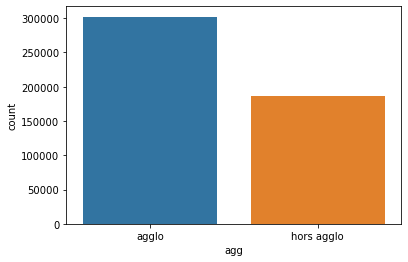

agglo         302031
hors agglo    186005
Name: agg, dtype: int64


In [30]:
plot_count("agg")

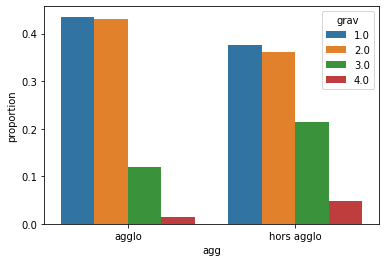

In [31]:
plot_grav("agg")

### `place` [++]

La très grande majorité des accidents recencés implique le conducteur (place 1). Cela fait sens lorsque l'on sait que de nombreux trajets en voiture se font avec un seul passager : le conducteur.
Les passagers avant (place 2) et les piétons (place 10) sont les plus touchés après les conducteurs. Les accidents impliquant des personnes à d'autres places restent très peu fréquents.

Clairement, on obtient des profils de gravité assez différents, les piétons ne sortant quasiment jamais indemmes des accidents.

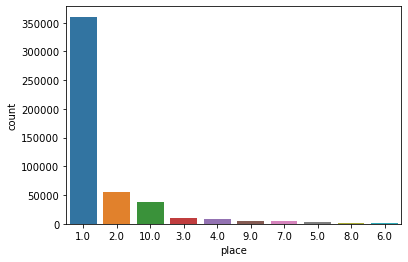

1.0     360351
2.0      55951
10.0     38578
3.0       9438
4.0       8547
9.0       5106
7.0       4669
5.0       2631
8.0       2123
6.0        642
Name: place, dtype: int64


In [32]:
plot_count("place")

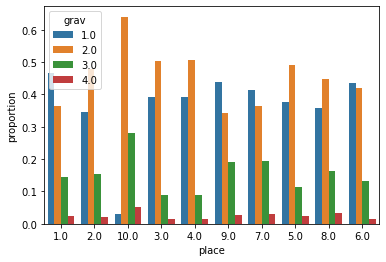

In [33]:
plot_grav("place")

### `catu` [+++]

On retrouve les mêmes conclusions que le diagramme à barres précédent lorsque l'on se concentre sur la catégorie des usagers : les conducteurs sont les premiers touchés des accidents de la route, suivis des passagers puis des piétons.
En revanche, les piétons sont les plus touchés par les accidents de gravité 2, 3 et 4.

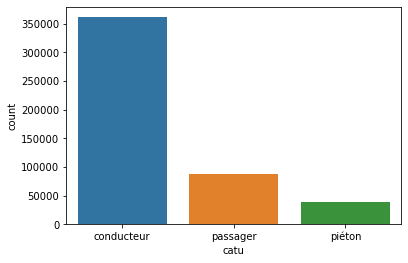

conducteur    361126
passager       88332
piéton         38578
Name: catu, dtype: int64


In [34]:
plot_count("catu")

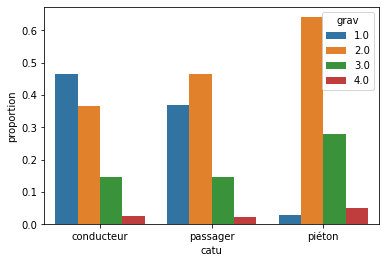

In [35]:
plot_grav("catu")

### `sexe` [++]

Les hommes sont plus touchés par les accidents de la route que les femmes.

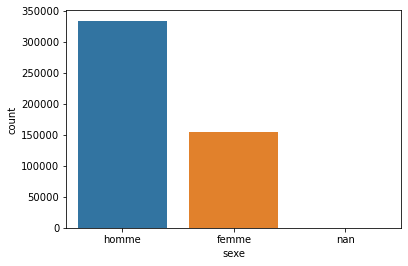

homme    333593
femme    154439
nan           4
Name: sexe, dtype: int64


In [36]:
plot_count("sexe")

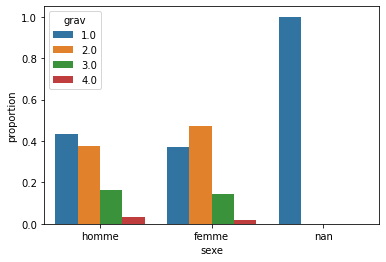

In [37]:
plot_grav("sexe")

Notons un phénomène rigolo : les femmes ont des séquelles de moindre gravité que les hommes en tant que conductrices, mais plus importantes en tant que passagères.

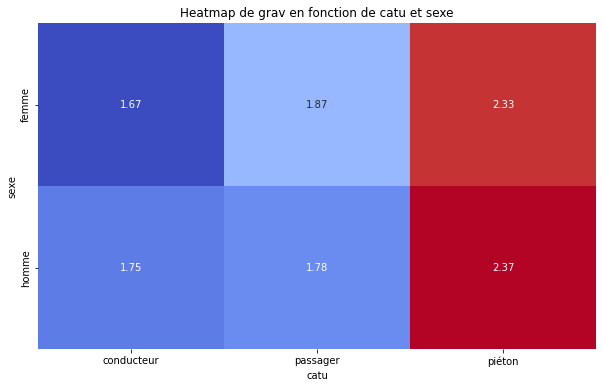

In [38]:
heatmap_grav("catu", "sexe")

### `an_nais` [+] (année de naissance)

On remarque un pic d'accidents chez les personnes nées aux alentours de l'année 2000. Comme les données que nous utilisons proviennent des années 2019, 2020, 2021 et 2022, et que les jeunes conducteurs comptent parmi les catégories les plus à risque, ce résultat semble cohérent. 

<AxesSubplot:xlabel='an_nais', ylabel='Density'>

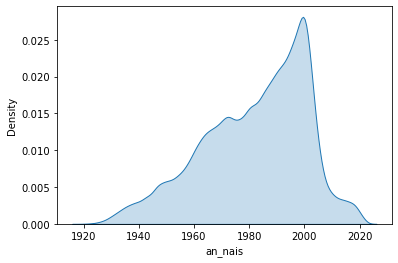

In [39]:
var = "an_nais"
sns.kdeplot(df_merged[var], fill=True)

Par curiosité, on peut regarder ce qui se passe chez les piétons uniquement, et là encore, les jeunes des années 2000 sont les plus touchés.

<AxesSubplot:xlabel='an_nais', ylabel='Density'>

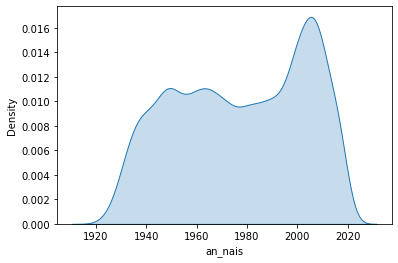

In [40]:
var = "an_nais"
sns.kdeplot(df_pieton[var], fill=True)

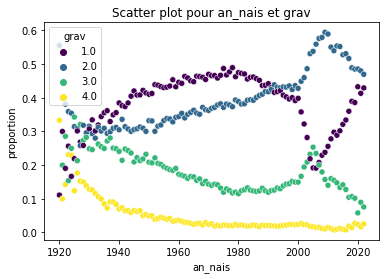

In [41]:
var = "an_nais"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.scatterplot(data=proportions, x=var, y='proportion', hue='grav', palette='viridis')
plt.title('Scatter plot pour an_nais et grav')
plt.show()

### `heure` [+, 2]

<AxesSubplot:xlabel='h', ylabel='Density'>

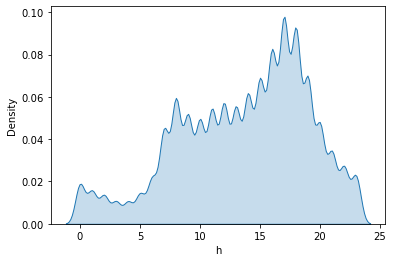

In [42]:
sns.kdeplot(df_merged["h"], fill=True)

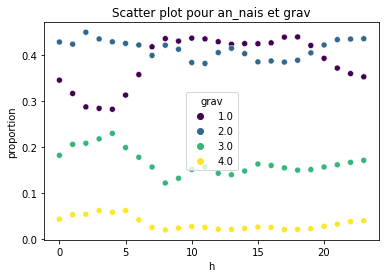

In [43]:
var = "h"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.scatterplot(data=proportions, x=var, y='proportion', hue='grav', palette='viridis')
plt.title('Scatter plot pour an_nais et grav')
plt.show()

On crée une nouvelle variable catégorielle, qui indique si l'heure est inférieure à 7, supérieure à 20 ou autre (car c'est là qu'il semble y avoir le plus de changements).

In [44]:
df_merged["heure_2"] = np.where(df_merged["h"] < 7, 0,
                                np.where(df_merged["h"] >= 20, 1, 2))

### `nbv` [+, 2]

La plus grande part des accidents recencés a lieu sur des 2 voies. Il y a très peu d'observations pour des routes à plus de 4 voies, ce qui fait sens étant donné que ces routes sont beaucoup moins fréquentes en France.

Note : on pourrait se dire que les valeurs au-delà de 8 voies par exemple sont aberrantes, mais il s'agit peut-être des péages. Dans le doute, on préfère les conserver.

[Second graphique] Le nombre de voies ne semble pas, ou peu, affecter la gravité de l'accident.

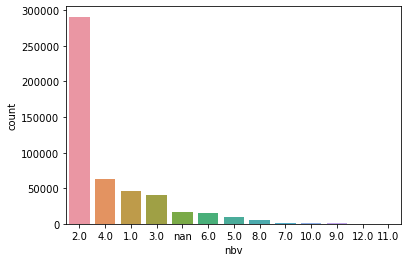

2.0     291008
4.0      62290
1.0      45860
3.0      40807
nan      15886
6.0      14547
5.0       9075
8.0       4710
7.0       1581
10.0      1116
9.0        727
12.0       237
11.0       192
Name: nbv, dtype: int64


In [45]:
plot_count("nbv")

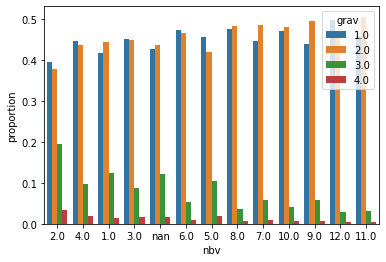

In [46]:
plot_grav("nbv")

In [47]:
df_merged["nbv_2"] = np.where(df_merged["nbv"].isin([2]), 0,
                              np.where(df_merged["nbv"].isin([1, 3, 4, 5]), 1, 2))

### `trajet` [+]

La catégorie de trajet la plus touchée par les accidents de circulation est celle de "promenade-loisir". On remarque tout de même de nombreuses valeurs manquantes pour cette variable.

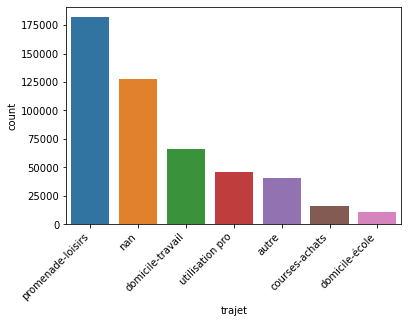

promenade-loisirs    181978
nan                  127339
domicile-travail      65767
utilisation pro       46068
autre                 40425
courses-achats        16050
domicile-école        10409
Name: trajet, dtype: int64


In [48]:
plot_count("trajet", rotation=True)

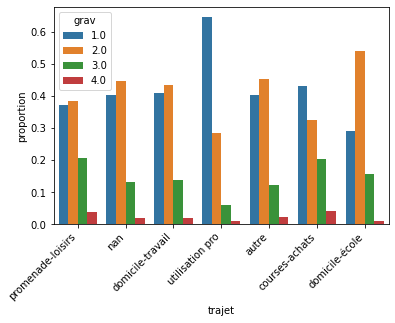

In [49]:
plot_grav("trajet", rotation=True)

### `lum` [+, 2]

La majeure partie des accidents a lieu en plein jour. 
Alors que l'on pourrait s'attendre à ce qu'il y ait plus d'accidents la nuit sans éclairage public qu'avec, c'est l'inverse que nous montre les données. Cela vient peut-être du fait que de plus en plus de routes sont éclairées de nuit, ou du fait que les routes éclairées sont plus utilisées.

Sur le second graphique, on remarque que la gravité des accidents semble peu affectée par le fait qu'il fasse nuit avec éclairage public, par rapport au plein jour. Les accidents de gravité 3 et 4 sont plus fréquents la nuit sans éclairage public.

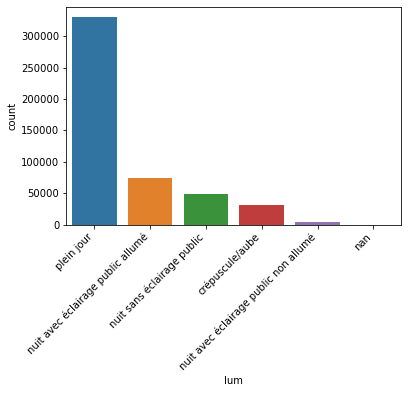

plein jour                               329764
nuit avec éclairage public allumé         74425
nuit sans éclairage public                48390
crépuscule/aube                           31224
nuit avec éclairage public non allumé      4224
nan                                           9
Name: lum, dtype: int64


In [50]:
plot_count("lum", rotation=True)

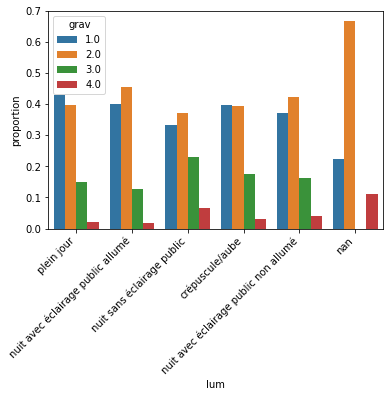

In [51]:
plot_grav("lum", rotation=True)

In [52]:
df_merged["lum_2"] = np.where(df_merged["lum"].isin(["plein jour", "nuit avec éclairage public allumé"]), 1, 0)

### `surf` [-] (surface)

Il n'y a que 2 modalités aux effectifs importants ("normale" et "mouillée"), et leur profil de gravité est très similaire. On ne s'attend donc pas à ce que cette variable joue un rôle important dans la prédiction ou l'estimation de la gravité des accidents.

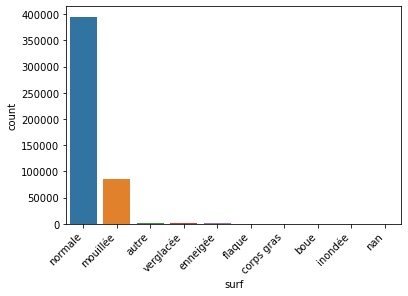

normale       395001
mouillée       86080
autre           2249
verglacée       1849
enneigée         906
flaque           707
corps gras       631
boue             271
inondée          229
nan              113
Name: surf, dtype: int64


In [53]:
plot_count("surf", rotation=True)

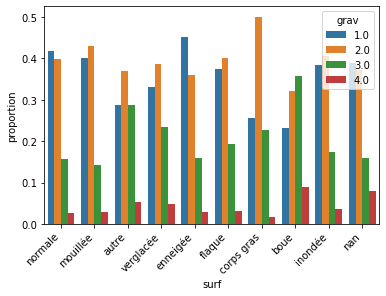

In [54]:
plot_grav("surf", rotation=True)

### `atm` [-] (conditions atmosphériques)

Comme la variable "surf", la variables sur les conditions atmoshpériques a des modalités dont les effectifs sont les plus significatifs avec des profils de gravité très similaires.

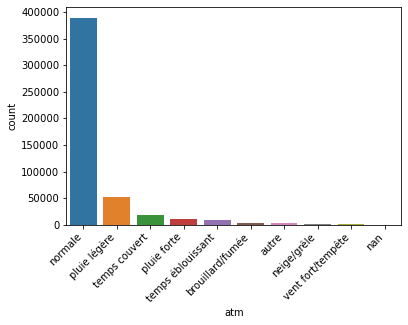

normale              390118
pluie légère          51371
temps couvert         18098
pluie forte           10501
temps éblouissant      9108
brouillard/fumée       3398
autre                  2241
neige/grêle            1898
vent fort/tempête      1271
nan                      32
Name: atm, dtype: int64


In [55]:
plot_count("atm", rotation=True)

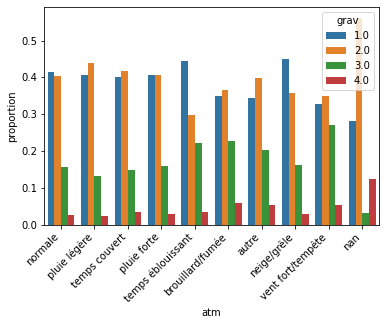

In [56]:
plot_grav("atm", rotation=True)

### `int` [-] (intersection)

Les modalités dont les effectifs sont significatifs ont des profils de gravité trop similaires.

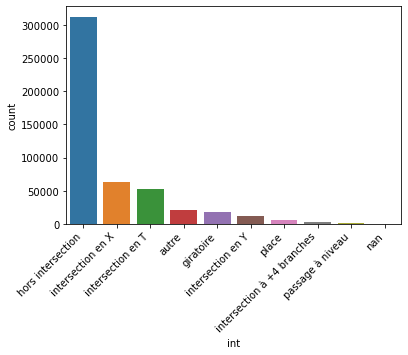

hors intersection             312891
intersection en X              63204
intersection en T              52329
autre                          21212
giratoire                      18217
intersection en Y              11107
place                           5220
intersection à +4 branches      2936
passage à niveau                 899
nan                               21
Name: int, dtype: int64


In [57]:
plot_count("int", rotation=True)

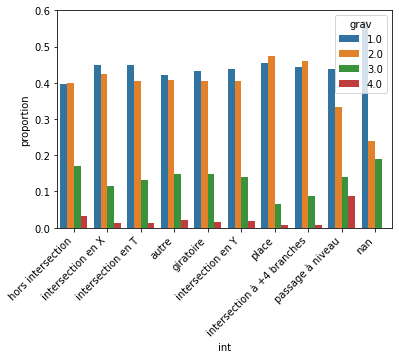

In [58]:
plot_grav("int", rotation=True)

### `col` [++, 2] (collision)

La plupart des accidents avec collision impliquent 2 véhicules.

[Second graphique] Les profils de gravité sont variés : par exemple, les collisions frontales sont à l'origine de plus d'accidents de gravité 3 ou 4 que les collisions sur le côté.

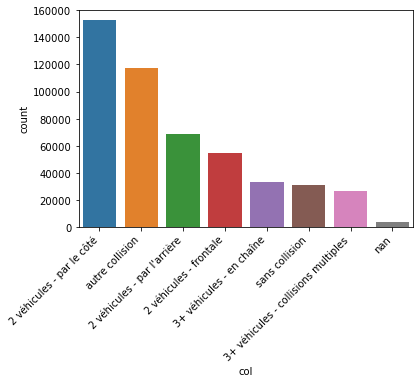

2 véhicules - par le côté              152932
autre collision                        117510
2 véhicules - par l'arrière             68714
2 véhicules - frontale                  54369
3+ véhicules - en chaîne                33043
sans collision                          31151
3+ véhicules - collisions multiples     26451
nan                                      3866
Name: col, dtype: int64


In [59]:
plot_count("col", rotation=True)

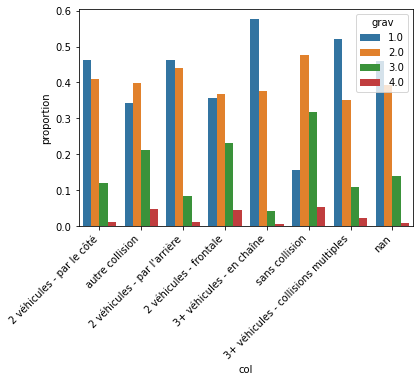

In [60]:
plot_grav("col", rotation=True)

On crée une nouvelle variable pour rassembler les modalités aux profils de gravité similaires.

In [61]:
df_merged["col_2"] = np.where(df_merged["col"].isin(["autre collision", "2 véhicules - frontale", "sans collision"]), 1, 0)

### `catr` [+, 2] (catégorie route)

Les accidents sont plus graves sur les routes départementales et nationales, étonnamment plus que sur les autoroutes.

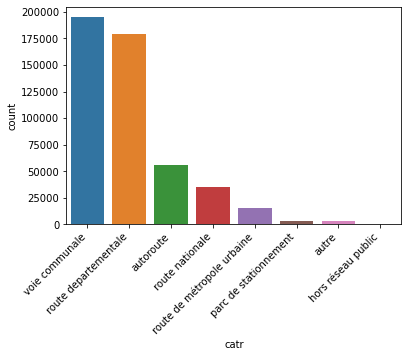

voie communale                194889
route departementale          179130
autoroute                      56333
route nationale                35034
route de métropole urbaine     15779
parc de stationnement           3283
autre                           3076
hors réseau public               512
Name: catr, dtype: int64


In [62]:
plot_count("catr", rotation=True)

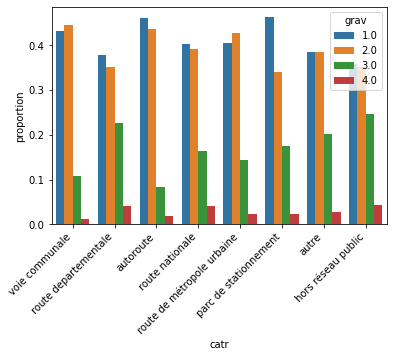

In [63]:
plot_grav("catr", rotation=True)

On crée une nouvelle variable pour rassembler les modalités aux profils de gravité similaires.

In [64]:
df_merged["catr_2"] = np.where(df_merged["catr"].isin(["route départementale", "hors réseau public"]), 0,
                               np.where(df_merged["catr"].isin(["route nationale", "route de métropole urbaine",
                                                               "parc de stationnement", "autre"]), 1, 2))

### `circ` [++] (régime de circulation)

Les chaussées bidirectionnelle sont les plus touchées par des accidents de la route, et entraînent un nombre plus important d'accidents de gravité 3 ou 4.

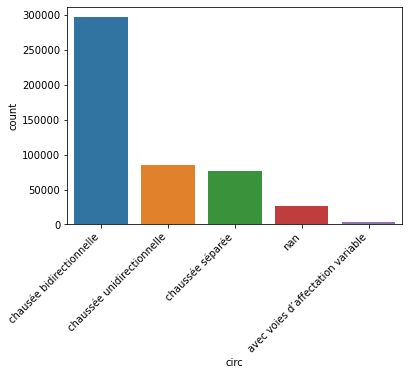

chausée bidirectionnelle             296929
chaussée unidirectionnelle            84865
chaussée séparée                      77210
nan                                   25877
avec voies d’affectation variable      3155
Name: circ, dtype: int64


In [65]:
plot_count("circ", rotation=True)

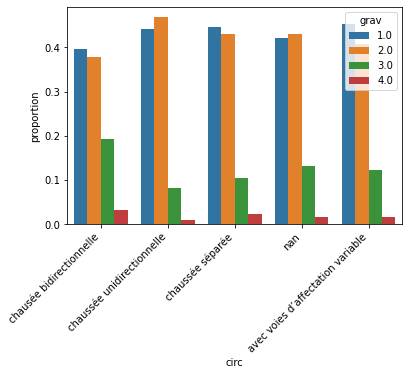

In [66]:
plot_grav("circ", rotation=True)

### `vosp` [-] (voie réservée)

La variable "voie réservée" comprend un nombre très important de `NaN`, et les profils de gravités des autres modalités sont similaires.

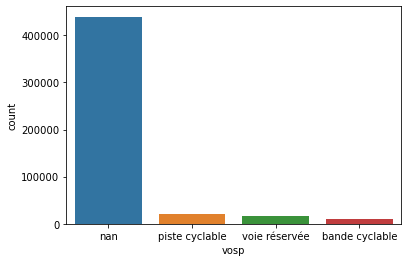

nan               439280
piste cyclable     21272
voie réservée      16784
bande cyclable     10700
Name: vosp, dtype: int64


In [67]:
plot_count("vosp")

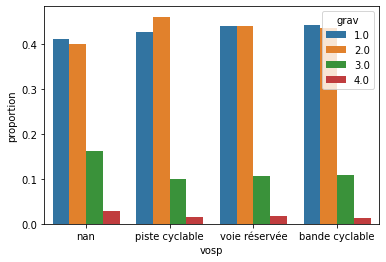

In [68]:
plot_grav("vosp")

### `prof` [-] (déclivité de la route)

Les modalités ont des profils de gravité trop similaires.

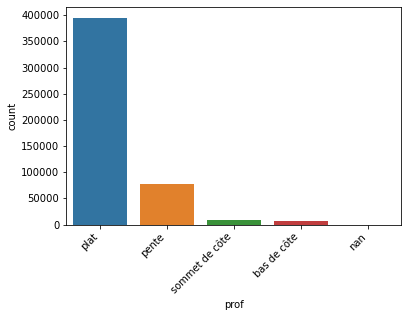

plat              395498
pente              76880
sommet de côte      8480
bas de côte         7100
nan                   78
Name: prof, dtype: int64


In [69]:
plot_count("prof", rotation=True)

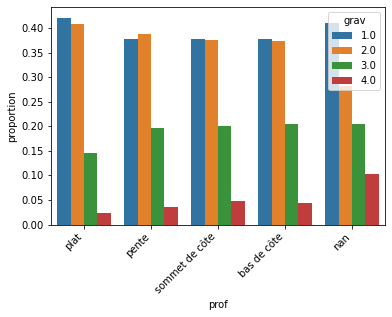

In [70]:
plot_grav("prof", rotation=True)

### `plan` [+, 2] (tracé en plan)

On remarque qu'une grande partie des accidents observés a lieu sur des parties rectilignes, mais que la gravité est plus importante lorsqu'il y a des virages (courbe à gauche, droite ou en "S").

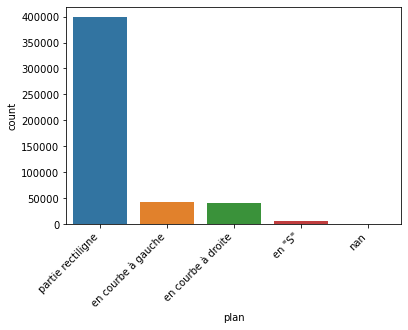

partie rectiligne     398913
en courbe à gauche     42400
en courbe à droite     40542
en "S"                  6121
nan                       60
Name: plan, dtype: int64


In [71]:
plot_count("plan", rotation=True)

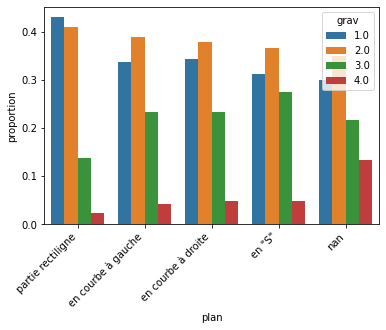

In [72]:
plot_grav("plan", rotation=True)

In [73]:
df_merged["plan_2"] = np.where(df_merged["plan"].isin(["partie rectiligne"]), 1, 0)

### `infra` [-] (aménagement, infrastructure)

Il y a _a priori_ trop de `NaN` pour utiliser cette variable, et les profils de gravité sont assez similaires.

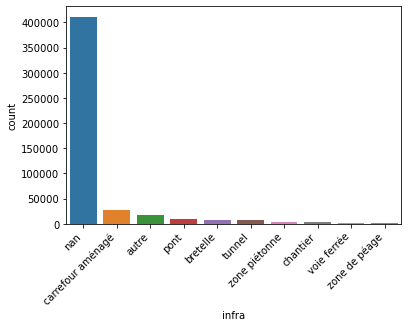

nan                  411465
carrefour aménagé     27845
autre                 17077
pont                   8852
bretelle               6758
tunnel                 6400
zone piétonne          3988
chantier               3745
voie ferrée            1538
zone de péage           368
Name: infra, dtype: int64


In [74]:
plot_count("infra", rotation=True)

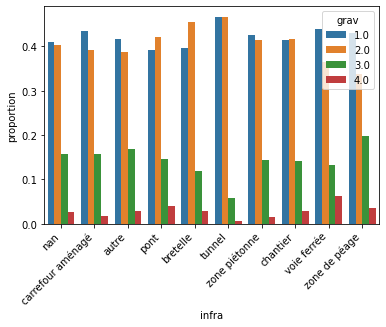

In [75]:
plot_grav("infra", rotation=True)

### `situ` [+, 2] (situation de l'accident)

Si la plupart des accidents ont lieu sur la chaussée, les profils de gravité sont très variés pour l'ensemble des modalités.

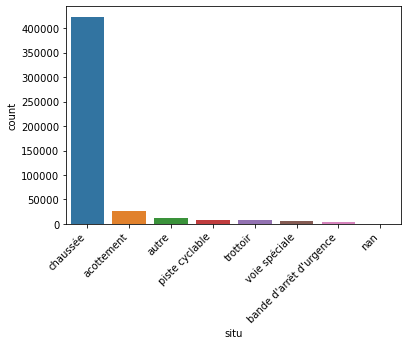

chaussée                   423281
acottement                  26290
autre                       12142
piste cyclable               8590
trottoir                     7614
voie spéciale                5558
bande d'arrêt d'urgence      4287
nan                           274
Name: situ, dtype: int64


In [76]:
plot_count("situ", rotation=True)

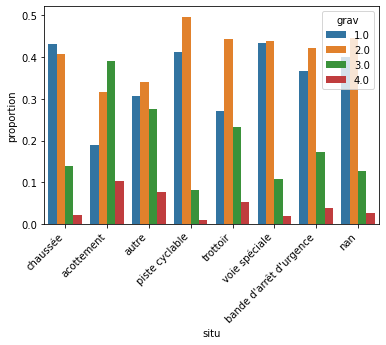

In [77]:
plot_grav("situ", rotation=True)

On crée une nouvelle variable, qui dit si l'accident a lieu sur un acottement, sur un trottoir ou "autre", ou sur le reste.

In [78]:
df_merged["situ_2"] = np.where(df_merged["situ"].isin(["acottement"]), 0, 
                               np.where(df_merged["situ"].isin(["autre", "trottoir"]), 1, 2))

### `obs` [-] (type d'obstacle fixe heurté)

Quasiment toutes les observations sont des "sans objet" (valeur 0.0) puisque ce sont essentiellement des obstacles mobiles qui sont heurtés. Cette variable présente donc peu d'intérêt pour notre étude.

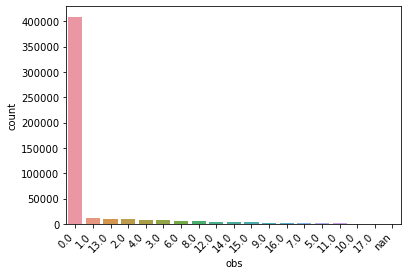

0.0     409038
1.0      11550
13.0     10101
2.0       8792
4.0       7498
3.0       7407
6.0       6596
8.0       6508
12.0      3820
14.0      3628
15.0      3308
9.0       2584
16.0      2227
7.0       1672
5.0        956
11.0       926
10.0       640
17.0       630
nan        155
Name: obs, dtype: int64


In [79]:
plot_count("obs", rotation=True)

### `obsm` [+, 2] (type d'obstacle mobile heurté)

On voit dans ce diagramme qu'une grande partie des accidents impliquent au moins 2 véhicules. Le reste des accidents les plus fréquents n'impliquent soit qu'un véhicule, soit un véhicule et un (ou plusieurs) piéton. Les profils de gravité diffèrent pour chacune des modalités.

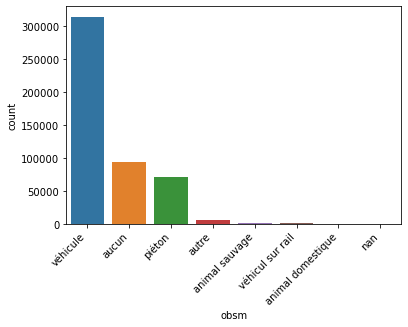

véhicule             313865
aucun                 94355
piéton                71208
autre                  6254
animal sauvage         1279
véhicul sur rail        473
animal domestique       378
nan                     224
Name: obsm, dtype: int64


In [80]:
plot_count("obsm", rotation=True)

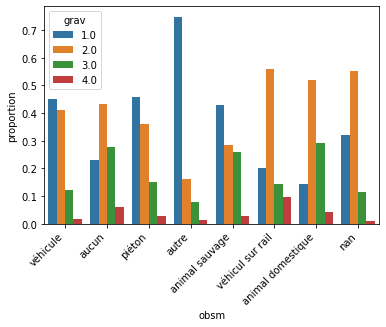

In [81]:
plot_grav("obsm", rotation=True)

In [82]:
df_merged["obsm_2"] = np.where(df_merged["obsm"].isin(["aucun"]), 0, 
                               np.where(df_merged["obsm"].isin(["autre"]), 1, 2))

### `choc` [+] (point de choc initial)

La majorité relative des chocs ont lieu à l'avant du véhicule, mais tous les types de chocs sont substantiellement représentés parmi les accidents.

Les modalités ont des profils de gravité relativement différents ; variable passablement utile, donc.

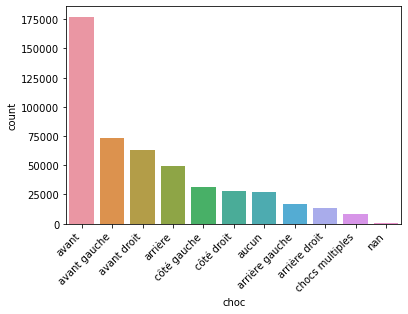

avant              177218
avant gauche        73032
avant droit         63331
arrière             49084
côté gauche         31673
côté droit          27942
aucun               26881
arrière gauche      16963
arrière droit       13556
chocs multiples      8162
nan                   194
Name: choc, dtype: int64


In [83]:
plot_count("choc", rotation=True)

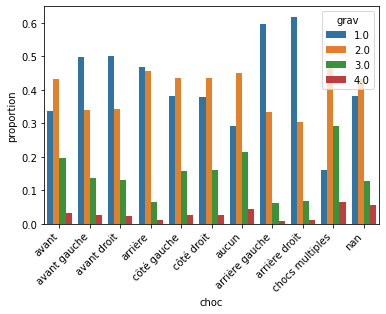

In [84]:
plot_grav("choc", rotation=True)

### `manv` [+] (manoeuvre principale avant l'accident)

De nombreuses modalités ont un nombre d'observations substantielles (même si la plupart des accidents ont lieu sans changement de direction).

Les profils de gravité sont également assez différents ; la variable sera sans doute plutôt utile, en particulier certaines modalités au profil assez différent ("tournant à gauche" et "entre deux files" par exemple).

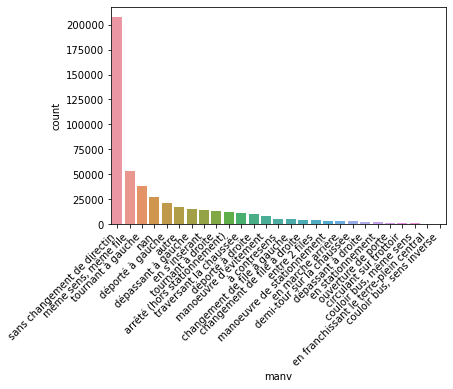

sans changement de directin               207357
même sens, même file                       53815
tournant à gauche                          38420
nan                                        27023
déporté à gauche                           21053
autre                                      17251
dépassant à gauche                         15733
en s'insérant                              13952
tournant à droite                          13159
arrêté (hors stationnement)                12442
traversant la chaussée                     11751
déporté à droite                           10575
manoeuvre d'évitement                       7867
à contresens                                5002
changement de file à gauche                 4975
changement de file à droite                 4419
entre 2 files                               4384
manoeuvre de stationnement                  3207
en marche arrière                           3099
demi-tour sur la chaussée                   3070
dépassant à droite  

In [85]:
plot_count("manv", rotation=True)

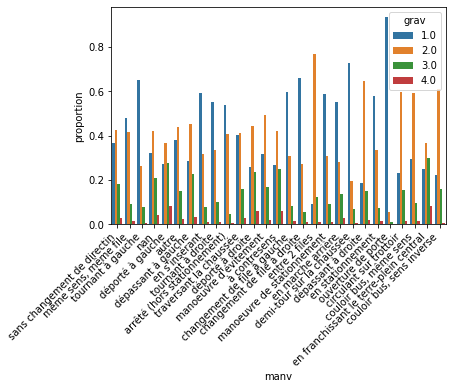

In [86]:
plot_grav("manv", rotation=True)

### `motor` [+] (motorisation du véhicule)

Sans surprise, pour la plupart des victimes, un véhicule à hydrocarbures est impliqué dans l'accident : ils représentent l'immense majorité des véhicules.

Sur le second graphique, on note de façon peu surprenante que les accidents sont plus graves lorsqu'il s'agit d'un véhicule à énergie humaine (vélo par exemple).

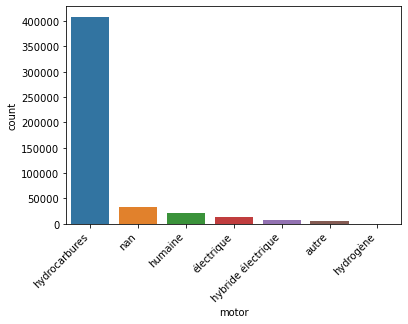

hydrocarbures         408860
nan                    32737
humaine                20740
électrique             13169
hybride électrique      7908
autre                   4322
hydrogène                300
Name: motor, dtype: int64


In [87]:
plot_count("motor", rotation=True)

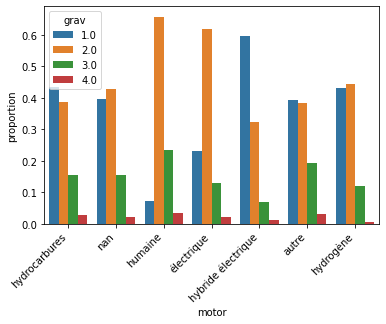

In [88]:
plot_grav("motor", rotation=True)

### `locp` [-] (localisation du piéton)

_Note : pour cette variable et les 2 suivantes, qui sont relatifs au piéton, on utilise `df_pieton` pour ne garder que les observations dont la victime est un piéton, logiquement._

Les modalités dont les effectifs sont significatifs ont des profils de gravité trop similaires.

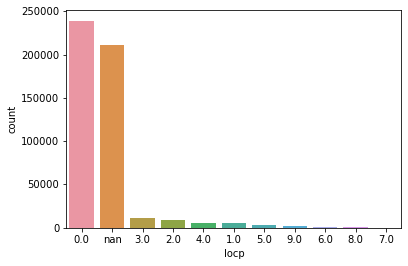

0.0    238998
nan    211181
3.0     11775
2.0      8429
4.0      5677
1.0      5510
5.0      2928
9.0      1841
6.0      1109
8.0       546
7.0        42
Name: locp, dtype: int64


In [89]:
plot_count("locp")

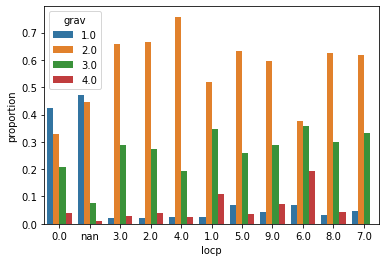

In [90]:
plot_grav("locp")

### `actp` [-] (action du piéton)

La variable est trop peu variée pour être intéressante à exploiter. De plus, les profils de gravité sont peu distincts.

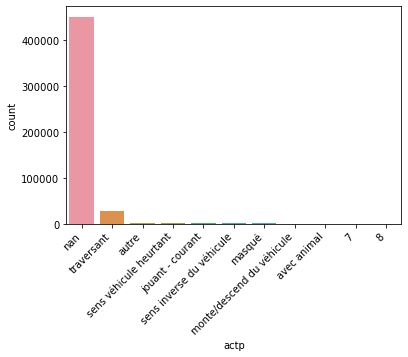

nan                          451269
traversant                    27896
autre                          2532
sens véhicule heurtant         2474
jouant - courant               1531
sens inverse du véhicule       1163
masqué                          531
monte/descend du véhicule       422
avec animal                     106
7                                60
8                                52
Name: actp, dtype: int64


In [91]:
plot_count("actp", rotation=True)

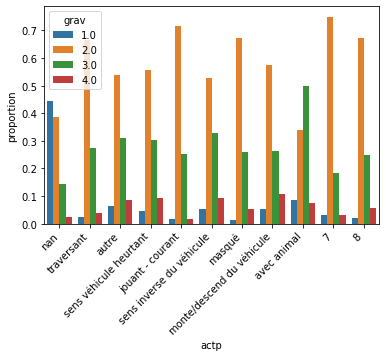

In [92]:
plot_grav("actp", rotation=True)

### `etatp` [-] (piéton seul, accompagné ou en groupe)

Profils de gravité trop similaires.

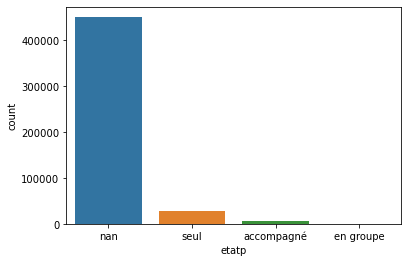

nan           450115
seul           28850
accompagné      7562
en groupe       1509
Name: etatp, dtype: int64


In [93]:
plot_count("etatp")

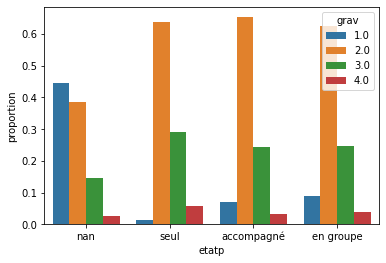

In [94]:
plot_grav("etatp")

### `jour` [-]

Les variables "jour" et "mois" ne semblent pas particulièrement explicatives de la gravité d'un accident. Les profils de gravité sont identiques peu importe le mois, et peu importe le jour du mois. Il n'y a pas d'effet "temps" visible (sauf pour les 31 du mois où on observe logiquement moins d'accidents, puisque tous les mois ne comportent pas 31 jours, et pour les mois d'été où la fréquence des accidents est un peu plus élevés, due aux vacances).

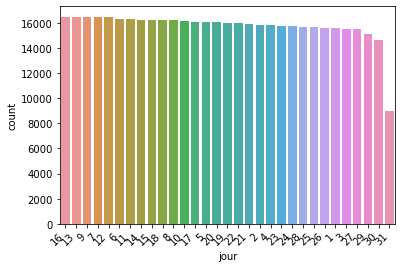

16    16511
13    16495
9     16487
7     16478
12    16448
6     16336
11    16306
14    16278
15    16272
18    16271
8     16212
10    16144
17    16092
5     16069
20    16067
19    16040
22    15996
21    15927
2     15877
4     15858
23    15774
24    15726
28    15668
25    15660
26    15619
1     15610
3     15551
27    15538
29    15136
30    14638
31     8952
Name: jour, dtype: int64


In [95]:
plot_count("jour", rotation=True)

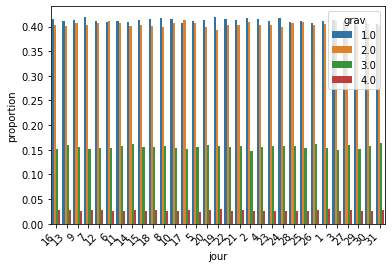

In [96]:
plot_grav("jour", rotation=True)

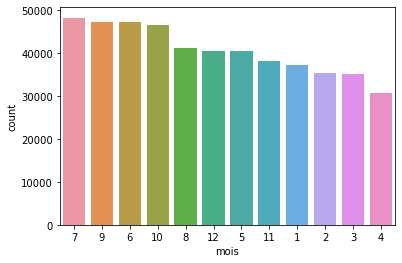

7     48279
9     47210
6     47167
10    46689
8     41159
12    40536
5     40428
11    38147
1     37317
2     35424
3     35056
4     30624
Name: mois, dtype: int64


In [97]:
plot_count("mois")

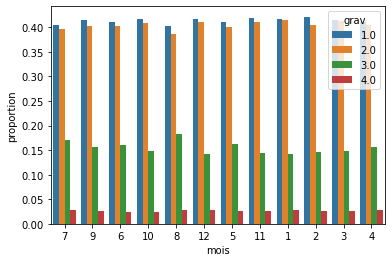

In [98]:
plot_grav("mois")

### `catv` [++, 2]

On a essentiellement des véhicules de type 7 (véhicules légers = voitures normales).

Les profils de gravité sont très variés. On a créé préalablement (via la fonction `clean_df_vehicules`) une variable `catv_2` qui classifie les véhicules en un nombre plus restreint de catégories, sur lesquels on dit quelques mots en-dessous.


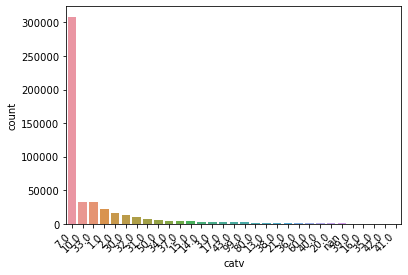

7.0     308393
10.0     33155
33.0     33114
1.0      22000
2.0      16135
30.0     13946
32.0     10123
31.0      7439
50.0      5730
34.0      4904
37.0      4510
15.0      3901
14.0      3316
3.0       3140
17.0      2845
43.0      2374
99.0      2164
80.0      1939
13.0      1758
38.0      1676
21.0      1064
36.0       891
60.0       798
40.0       763
20.0       684
nan        667
39.0       207
16.0       138
35.0       109
42.0        95
41.0        58
Name: catv, dtype: int64


In [99]:
plot_count("catv", rotation=True)

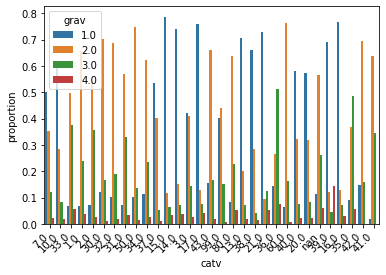

In [100]:
plot_grav("catv", rotation=True)

La proportion des différents véhicules impliqués dans des accidents est peu étonnante, elle reflète simplement la proportion des véhicules sur la route de manière assez générale.

Pour la gravité, les accidents à moto et en vélo sont beaucoup plus sévères, ce qui n'est pas une surprise.

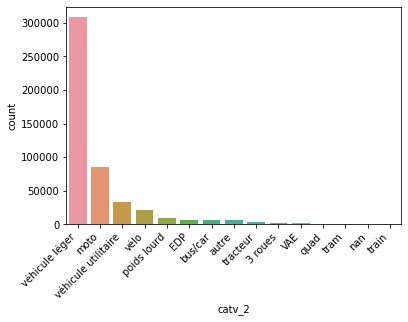

véhicule léger         308393
moto                    85661
véhicule utilitaire     33155
vélo                    22000
poids lourd              8975
EDP                      6528
bus/car                  6186
autre                    5988
tracteur                 4047
3 roues                  2527
VAE                      1939
quad                     1000
tram                      763
nan                       667
train                     207
Name: catv_2, dtype: int64


In [101]:
plot_count("catv_2", rotation=True)

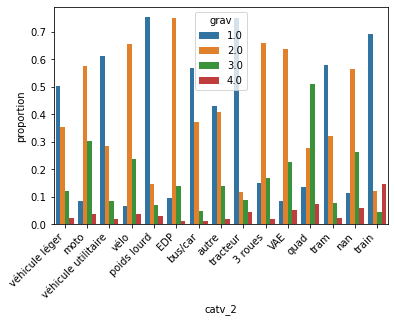

In [102]:
plot_grav("catv_2", rotation=True)

## Equipements

Dans cette section sur les équipements de sécurité, on utilise le dataframe `df_non_pieton` : en effet, le booléen prend forcément la valeur `False` pour les observations relatives aux piétons (puisque les variables correspondent à des équipements en voiture, sauf pour `gilet réfléchissant` et `autre`).

In [103]:
df_merged.groupby("catu")["ceinture", "dispositif enfants", "casque", "airbag", "gilet réfléchissant", "gants", "autre"].apply(lambda x: x.apply(pd.Series.value_counts)).unstack().fillna(0)

C:\Users\nahta\AppData\Local\Temp/ipykernel_25124/474840789.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_merged.groupby("catu")["ceinture", "dispositif enfants", "casque", "airbag", "gilet réfléchissant", "gants", "autre"].apply(lambda x: x.apply(pd.Series.value_counts)).unstack().fillna(0)


ceinture           dispositif enfants            casque           \
               False      True              False    True     False     True   
catu                                                                           
conducteur  132960.0  228166.0           361119.0     7.0  277007.0  84119.0   
passager     23938.0   64394.0            84642.0  3690.0   80397.0   7935.0   
piéton       38578.0       0.0            38578.0     0.0   38578.0      0.0   

              airbag         gilet réfléchissant           gants           \
               False    True               False  True     False     True   
catu                                                                        
conducteur  355632.0  5494.0              356559  4567  318525.0  42601.0   
passager     87118.0  1214.0               87845   487   84725.0   3607.0   
piéton       38578.0     0.0               38386   192   38578.0      0.0   

             autre        
             False  True  
catu                      
conducteur  356508  4618  
passager     87566   766  
piéton       38463   115

### `ceinture` [+++]

On constate que le tiers des victimes (conducteurs ou passagers) recensées ne portaient pas la ceinture... C'est en réalité curieux car _a priori_ il ne devrait pas y avoir de corrélation entre le fait de ne pas porter la ceinture et d'être victime d'un accident (mais seulement entre le fait de ne pas porter la ceinture et le fait d'être gravement touché, conditionnellement au fait d'être victime d'un accident).

Le second graphique montre très clairement que la ceinture est déterminante dans la gravité de l'accident...

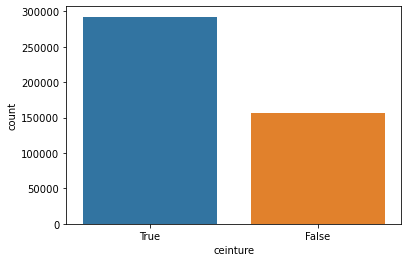

True     292560
False    156898
Name: ceinture, dtype: int64


In [104]:
plot_count("ceinture", df_non_pieton)

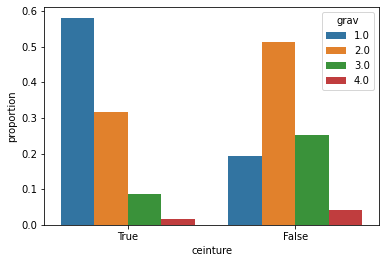

In [105]:
plot_grav("ceinture", df_non_pieton)

### `dispositif enfants` [-]

Il y a très peu d'observations pour lesquelles on note la présence d'un dispositif enfants, et même avec ça, la gravité des accidents lorsqu'il y a un dispositif enfant est peu différente de celle sans.

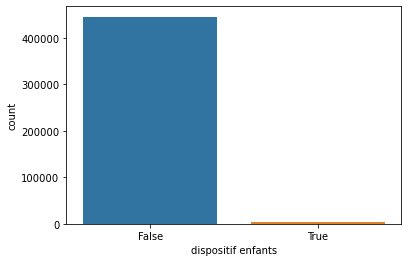

False    445761
True       3697
Name: dispositif enfants, dtype: int64


In [106]:
plot_count("dispositif enfants", df_non_pieton)

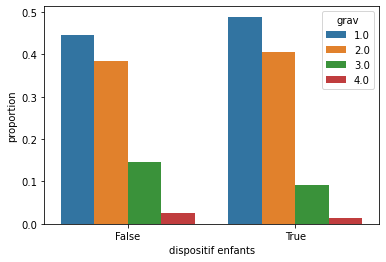

In [107]:
plot_grav("dispositif enfants", df_non_pieton)

### `casque` [+++]

On filtre le dataframe non piéton pour ne garder que les cas ou le véhicule impliqué est une moto ou un vélo, car le casque n'est pas pertinent dans les autres cas.

Le second graphique montre que la gravité des accidents est en fait sensiblement la même avec ou sans casque. Etonnant !

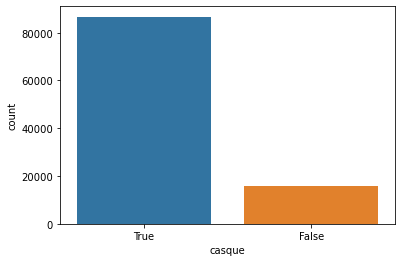

True     86688
False    15839
Name: casque, dtype: int64


In [108]:
plot_count("casque", df_non_pieton[df_non_pieton["catv_2"].isin(["moto", "vélo"])])

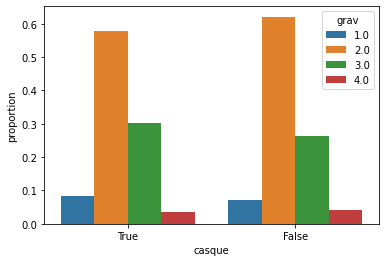

In [109]:
plot_grav("casque", df_non_pieton[df_non_pieton["catv_2"].isin(["moto", "vélo"])])

### `airbag` [-]

On a très peu d'observations avec airbag, et la gravité semble plus grande avec airbag. Conclusion à prendre avec des pincettes...

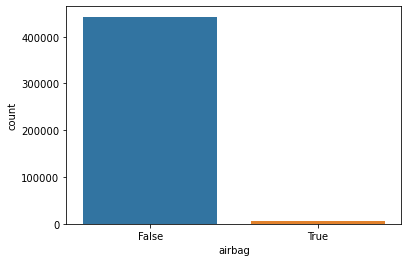

False    442750
True       6708
Name: airbag, dtype: int64


In [110]:
plot_count("airbag", df_non_pieton)

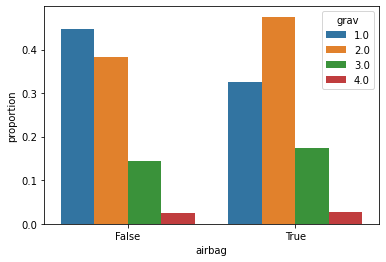

In [111]:
plot_grav("airbag", df_non_pieton)

### `gilet réfléchissant`

Globalement, on n'a très peu d'observations avec gilet réfléchissant, que ce soit pour les piétons ou les on piétons.

- Pour les non piétons, le gilet réfléchissant diminue légèrement la gravité.
- Pour les piétons, il est difficile de conclure...

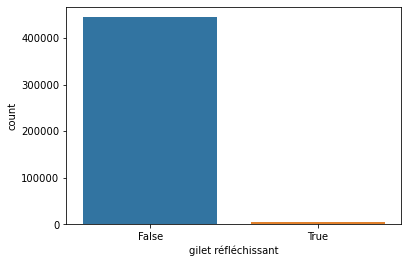

False    444404
True       5054
Name: gilet réfléchissant, dtype: int64


In [112]:
plot_count("gilet réfléchissant", df_non_pieton)

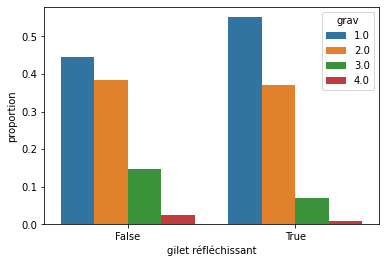

In [113]:
plot_grav("gilet réfléchissant", df_non_pieton)

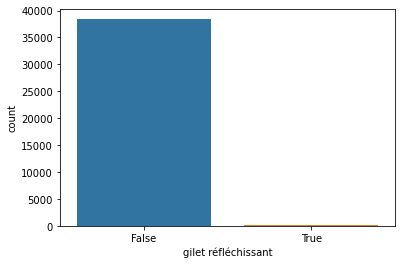

False    38386
True       192
Name: gilet réfléchissant, dtype: int64


In [114]:
plot_count("gilet réfléchissant", df_pieton)

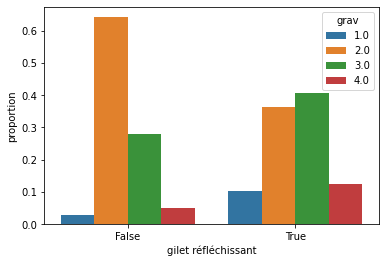

In [115]:
plot_grav("gilet réfléchissant", df_pieton)

### `gants`

Il est difficile de comprendre quel rôle peuvent bien jouer les gants dans tout ça...

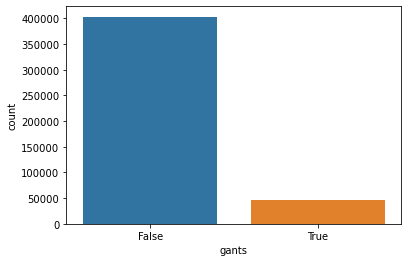

False    403250
True      46208
Name: gants, dtype: int64


In [116]:
plot_count("gants", df_non_pieton)

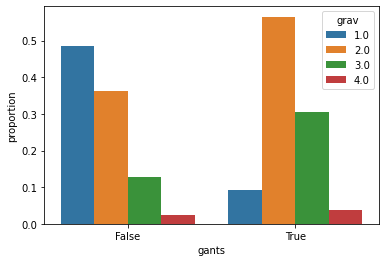

In [117]:
plot_grav("gants", df_non_pieton)

### `autre`

Sans plus de connaissances sur ce à quoi `autre` renvoie, il est difficile de tirer des conclusions pertinentes.

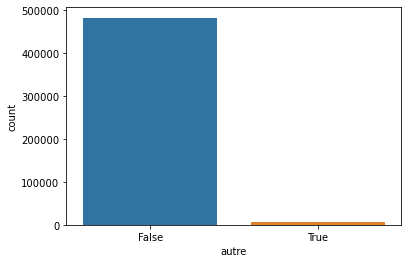

False    482537
True       5499
Name: autre, dtype: int64


In [118]:
plot_count("autre")

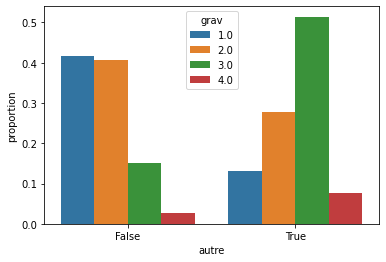

In [119]:
plot_grav("autre")

# Modélisation

Dans un premier temps, nous importons les packages nécessaires aux différentes analyses que nous souhaitons mener.

In [105]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

### Moindres Carrés Ordinaires (MCO)


La régression linéaire présente une utilité double. D'abord, elle constitue un moyen élémentaire pour anticiper la gravité des accidents routiers. De plus, les valeurs des coefficients et les tests de Student offrent un moyen efficace d'identifier les variables déterminantes. Ainsi, la régression linéaire permet la sélection de variables pertinentes pour les autres méthodes de prédiction.

In [106]:
# Création de variables catégorielles pertinentes en vue de la régression 
df_merged["moto"]=np.where(df_merged['catv_2'] == 'moto', 1, 0).astype(int)
df_merged["vélo"]=np.where(df_merged['catv_2'] == 'vélo', 1, 0).astype(int)
df_merged["poids lourd"]=np.where(df_merged['catv_2'] == 'poids lourd', 1, 0).astype(int)
df_merged["poids lourd"]=np.where(df_merged['catv_2'] == 'poids lourd', 1, 0).astype(int)

In [107]:
# Au vue des statistiques descriptives, ces variables semblent particulièrment déterminantes :
numeric_features = ["an_nais", "h", "vma"]
categorical_features = ["agg", "catu", "sexe", "nbv_2", "trajet", "lum_2", "col_2", 
                        "catr_2", "circ", "plan_2", "situ_2", "obsm_2", "ceinture","obsm","casque","gants","moto","vélo","poids lourd"]
df_elem1 = df_merged[["grav"] + numeric_features + categorical_features]
df_elem1.dropna(inplace=True)
df_elem1

/var/folders/5b/9tmp5hs93095pvvmmg6cwg5m0000gn/T/ipykernel_30907/4038503281.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_elem1.dropna(inplace=True)


,grav,an_nais,h,vma,agg,catu,sexe,nbv_2,trajet,lum_2,...,plan_2,situ_2,obsm_2,ceinture,obsm,casque,gants,moto,vélo,poids lourd
0,3.0,2008.0,16,50.0,agglo,conducteur,homme,0,promenade-loisirs,1,...,1,2,2,False,véhicule,True,False,1,0,0
1,1.0,1948.0,16,50.0,agglo,conducteur,homme,0,promenade-loisirs,1,...,1,2,2,True,véhicule,False,False,0,0,0
2,2.0,1988.0,8,50.0,agglo,conducteur,homme,0,autre,1,...,1,2,2,True,véhicule,False,False,0,0,0
3,1.0,1970.0,8,50.0,agglo,conducteur,homme,0,utilisation pro,1,...,1,2,2,True,véhicule,False,False,0,0,0
7,2.0,1967.0,18,30.0,agglo,piéton,femme,1,promenade-loisirs,1,...,1,2,2,False,piéton,False,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494174,2.0,1968.0,9,130.0,hors agglo,passager,homme,1,promenade-loisirs,1,...,1,2,2,True,véhicule,False,False,0,0,0
494175,1.0,1972.0,7,90.0,hors agglo,conducteur,femme,0,domicile-travail,1,...,1,2,2,True,véhicule,False,False,0,0,0
494176,2.0,1964.0,7,90.0,hors agglo,conducteur,homme,0,domicile-travail,1,...,1,2,2,True,véhicule,False,False,0,0,0
494177,2.0,1988.0,7,90.0,hors agglo,conducteur,femme,0,domicile-travail,1,...,1,2,2,True,véhicule,False,False,0,0,0


Encodage pour  la régression linéaire. création de variables binaires et conversion de format non prix par stat models en int 

In [108]:
# Binarisation 
df_elem1_bin=pd.get_dummies(df_elem1,columns=["agg", "catu", "sexe", "nbv_2", "trajet", "lum_2", "col_2", 
                        "catr_2", "circ", "plan_2", "situ_2", "obsm_2","obsm",],drop_first=True )# on drop pour éviter la colinéarité parfaite

In [109]:
# Conversions 
df_elem1_bin["an_nais"]=df_elem1_bin["an_nais"].astype(int)   # Statmodels ne prends les format DT.time  
df_elem1_bin['ceinture'] = df_elem1_bin['ceinture'].astype(int)  # ni les booléen il s'agit déja variables binaires
df_elem1_bin['casque'] = df_elem1_bin['casque'].astype(int) # idem
df_elem1_bin['gants'] = df_elem1_bin['gants'].astype(int)  # idem
df_elem1_bin.dropna(inplace=True)
df_elem1_bin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338311 entries, 0 to 494178
Data columns (total 39 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   grav                             338311 non-null  float64
 1   an_nais                          338311 non-null  int64  
 2   h                                338311 non-null  int64  
 3   vma                              338311 non-null  float64
 4   ceinture                         338311 non-null  int64  
 5   casque                           338311 non-null  int64  
 6   gants                            338311 non-null  int64  
 7   moto                             338311 non-null  int64  
 8   vélo                             338311 non-null  int64  
 9   poids lourd                      338311 non-null  int64  
 10  agg_hors agglo                   338311 non-null  bool   
 11  catu_passager                    338311 non-null  bool   
 12  catu_pi

In [110]:
df_elem1_bin

,grav,an_nais,h,vma,ceinture,casque,gants,moto,vélo,poids lourd,...,situ_2_1,situ_2_2,obsm_2_1,obsm_2_2,obsm_animal sauvage,obsm_aucun,obsm_autre,obsm_piéton,obsm_véhicul sur rail,obsm_véhicule
0,3.0,2008,16,50.0,0,1,0,1,0,0,...,False,True,False,True,False,False,False,False,False,True
1,1.0,1948,16,50.0,1,0,0,0,0,0,...,False,True,False,True,False,False,False,False,False,True
2,2.0,1988,8,50.0,1,0,0,0,0,0,...,False,True,False,True,False,False,False,False,False,True
3,1.0,1970,8,50.0,1,0,0,0,0,0,...,False,True,False,True,False,False,False,False,False,True
7,2.0,1967,18,30.0,0,0,0,0,0,0,...,False,True,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494174,2.0,1968,9,130.0,1,0,0,0,0,0,...,False,True,False,True,False,False,False,False,False,True
494175,1.0,1972,7,90.0,1,0,0,0,0,0,...,False,True,False,True,False,False,False,False,False,True
494176,2.0,1964,7,90.0,1,0,0,0,0,0,...,False,True,False,True,False,False,False,False,False,True
494177,2.0,1988,7,90.0,1,0,0,0,0,0,...,False,True,False,True,False,False,False,False,False,True


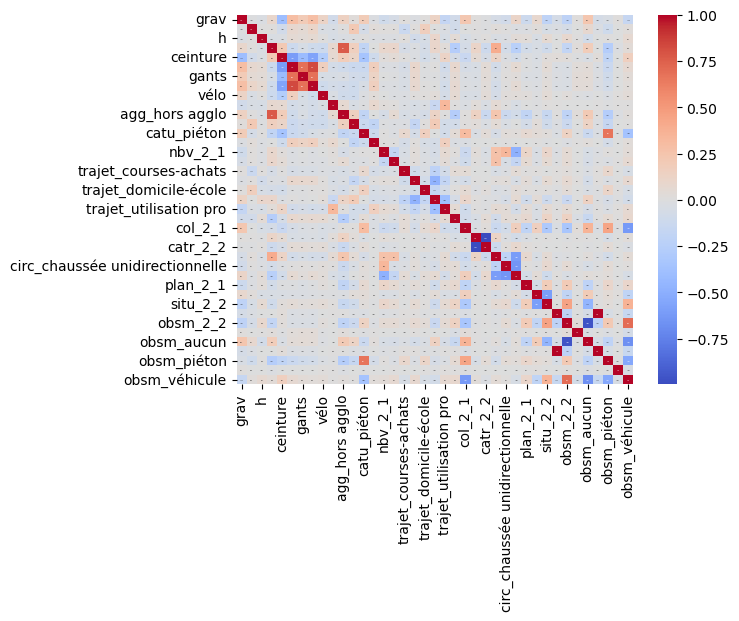

In [111]:
# Matrice de corrélation 
g = sns.heatmap(df_elem1_bin.corr(), cmap='coolwarm', annot=True, fmt=".2f",annot_kws={'size': 0.2})

La matrice de corrélation fait apparaître l'importance de certains variables telle que la ceinture, les gants,  la regression linéaire rend compte de façon éloquante de l'importances de ces variables. 

Mettre toutes les variables en numériques en créant df_elem2_bin sinon message d'erreur en tournant l'ols

In [112]:
df_elem2_bin = df_elem1_bin.astype(int)

In [113]:
# Regression linéaire avec l'ensemble des variables df_elem1
X = df_elem2_bin.drop('grav', axis=1)
y = df_elem2_bin['grav']
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary2())

                        Results: Ordinary least squares
Model:                  OLS                  Adj. R-squared:         0.351      
Dependent Variable:     grav                 AIC:                    672348.5454
Date:                   2023-12-29 19:19     BIC:                    672745.6191
No. Observations:       338311               Log-Likelihood:         -3.3614e+05
Df Model:               36                   F-statistic:            5088.      
Df Residuals:           338274               Prob (F-statistic):     0.00       
R-squared:              0.351                Scale:                  0.42715    
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------------
const                            5.7409   0.0971  59.1049 0.0000  5.5505  5.9313
an_nais                         -0.0030   0.0001 -46.

 Certaines de nos variables ne sont pas significatives : les p-value sont trop élevées, donc les hypothèses nulles ne peuvent être rejetées pour obsm_véhicule, circ_chaussée bidirectionnelle et trajet_domicile-travail au seuil de 10%, et pour catr_2_1 au seuil  de 5%.
 
Le R2 vaut 35,1% :  notre modèle a une certaine valeur préditive, mais une part de la variance de la gravité reste encore non expliquée. 

Au-delà de la question de la prédiction, il convient de s'intérroger  sur la valeur inférentielle de nos estimations : que peut-on déduire des valeurs des coefficients, sont-ils tous interprétables ? On constate que certaines variables semblent avoir une influence  particulièrement structurantes : toutes choses étant égales par ailleurs, le fait d'être un piéton accroît la gravité des accidents d'un point. De même, l'utilisation de la ceinture, la présence sur un vélo ou une moto ont un impact notable.

Le signe et la valeur  de certains coefficients soulève des interrogations : ceteris et paribus, le fait de porter un casque accroît la gravité d'environ 0.3 points. Cette valeur surprenante est probablement due à un problème de variables omises.


\begin{align*}
&\text{Soit la formule de variables omises avec :} \\
&\beta_l : \text{le coefficient dans la régression longue} \\
&\beta_s : \text{le coefficient dans la régression courte} \\
&\lambda : \text{le coefficient de } l \text{ dans la régression de } g \text{ sur } l \\
&\beta_g : \text{le coefficient dans la régression longue de } g \\
&\beta_s = \beta_l + \lambda \times \beta_g
\end{align*}

 Dans nos cas  le coeficient associé au casque est sans doute surestimé  puisque que corrélé avec des moyens transport  eux même corrélé positivement avec la gravité. Autrement dit, dans notre cas $\lambda$ et $\beta_g$ sont positifs, ce faisant $\beta_s$ est inférieur à $\beta_l$.


In [114]:
#selection du meilleur nombres de covariables à l'aide du R carré ajusté 
y = df_elem2_bin['grav']
X = df_elem2_bin.drop('grav', axis=1)
liste_r_carre_ajustes = []
for nb_variables in range(len(X.columns)):
    X_loop =  X.iloc[ :,:nb_variables+1]
    X_loop = sm.add_constant(X_loop)
    modele = sm.OLS(y,X_loop ).fit()
    liste_r_carre_ajustes.append(modele.rsquared_adj)

serie_r_carre_ajustes = pd.Series(liste_r_carre_ajustes)
serie_r_carre_ajustes.sort_values(ascending=False,)

36    0.351193
37    0.351192
35    0.350905
31    0.319775
32    0.319773
34    0.319773
33    0.319773
30    0.310953
29    0.308833
28    0.296137
27    0.293811
25    0.291668
26    0.291667
24    0.289769
23    0.289363
22    0.289355
21    0.289207
20    0.273880
19    0.270123
18    0.267918
17    0.262327
16    0.261983
15    0.261744
14    0.261611
13    0.256309
12    0.249849
11    0.248146
10    0.226768
9     0.224182
8     0.205737
7     0.200844
6     0.198710
5     0.197294
4     0.197238
3     0.192953
2     0.008303
1     0.000659
0     0.000117
dtype: float64

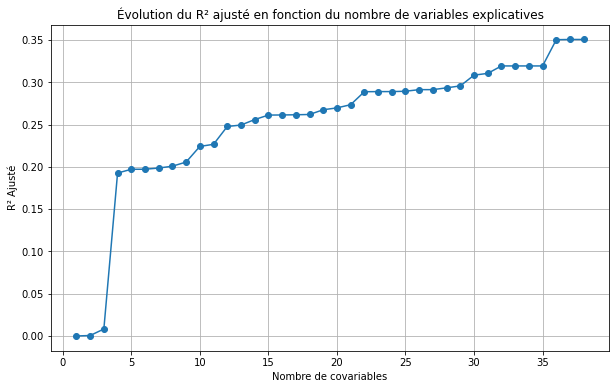

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(serie_r_carre_ajustes) + 1), serie_r_carre_ajustes, marker='o')
plt.title("Évolution du R² ajusté en fonction du nombre de variables explicatives")
plt.xlabel("Nombre de covariables")
plt.ylabel("R² Ajusté")
plt.grid(True)
plt.show()

Pour sélectionner le modèle le plus performant on utilise le R-carré-ajusté puisque  le R-carré croit mécaniquement avec l'ajout de covariables. la méthode employé est criticable à plusieurs titre. D'abord l'ajout des variables ce fait selon un odre arbitraire. De plus,  seul un seul ordre d'ajout de variables est testé. 


 Une régression linéaire avec le R-carré le plus élevé 
modèle plus pertinent : 

In [ ]:
#nombre_de_covariables_le_plus_pertinent= serie_r_carre_ajustes.idxmax()
#X_R_carre_max=X.iloc[ :,:nombre_de_covariables_le_plus_pertinent]
#X_R_carre_max = sm.add_constant(X_R_carre_max)
#model = sm.OLS(y, X)
#results = model.fit()
#print(results.summary2())
#(modele.rsquared_adj)

## Régression ordinale proportionnelle

On peut également utiliser une régression ordinale proportionnelle à la place de la régression MCO, puisque notre vaiable d'intérêt (la gravité) est une variable catégorielle ordonnée. On spécifie cela dans notre code :

In [ ]:
# Convertir la variable d'intérêt 'grav' en type catégorie ordonnée
df_elem2_bin['grav'] = pd.Categorical(df_elem2_bin['grav'], ordered=True)
# Régression ordinale proportionnelle
X = df_elem2_bin.drop('grav', axis=1)
X = sm.add_constant(X)
y = df_elem2_bin['grav']
model = sm.OLS(y, X)
ordinal_model = sm.OLS(y, X).fit(method='qr')
print(ordinal_model.summary())

On obient les mêmes résultats qu'avec notre régression MCO. Dans notre cas particulier, les différences entre ces deux approches ne sont donc pas critiques. L'objectif de la régression ordinale proportionnelle est de comprendre comment les caractérisituqes influent sur la probabilité d'appartenir à différentes catégories ordinales (ici, différents "types" de gravité). 
Une autre approche que l'on peut considérer avec une variable d'intérêt catégorielle ordonnée est la régression ordinale discriminante, dont le but est de séparer de manière optimale les différentes catégories de gravité.

## Régression ordinale discriminante

In [ ]:
pip install mord

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Supposons que 'grav' est votre variable cible et le reste des variables sont vos variables explicatives
# Remplacez les noms de colonnes par ceux de votre DataFrame

# Variables explicatives
X = df_elem2_bin.drop('grav', axis=1)

# Variable cible
y = df_elem2_bin['grav'].astype(int)  # Convertissez 'grav' en type int

# Divisez les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Appliquez l'analyse discriminante linéaire
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, y_train)

# Appliquez la régression logistique multinomiale sur les composantes LDA
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train_lda, y_train)

# Transformez les données de test avec LDA
X_test_lda = lda.transform(X_test)

# Faites des prédictions avec la régression logistique
y_pred = logreg.predict(X_test_lda)

# Évaluez la précision
accuracy = accuracy_score(y_test, y_pred)

# Affichez les résultats
print("Accuracy :", accuracy)

# Affichez les coefficients
print("Coefficients de la régression logistique multinomiale :")
for i in range(logreg.coef_.shape[0]):
    print(f"Coefficients pour la classe {i + 1} :", logreg.coef_[i])


## Régression Ridge avec validation croisée

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

X = df_elem2_bin.drop('grav', axis=1)
y = df_elem2_bin['grav']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des variables explicatives pour la régression Ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Spécification d'une plage de valeurs d'alpha à tester
alphas = [0.1, 1.0, 10.0]

ridge_cv_model = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv_model.fit(X_train_scaled, y_train)

# Meilleur alpha sélectionné par validation croisée
best_alpha = ridge_cv_model.alpha_
print(f'Meilleur alpha sélectionné = {best_alpha}')

y_pred = ridge_cv_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

coefficients_table = pd.DataFrame({'Feature': X.columns, 'Coefficient': ridge_cv_model.coef_})
print(coefficients_table)

print("Mean Squared Error (MSE) sur l'ensemble de test :", mse)
print("Coefficient de détermination (R2) sur l'ensemble de test :", r2)



Meilleur alpha sélectionné = 10.0
                            Feature  Coefficient
0                           an_nais    -0.054295
1                                 h    -0.022680
2                               vma     0.055508
3                          ceinture    -0.153727
4                            casque     0.090493
5                             gants    -0.007898
6                              moto     0.098398
7                              vélo     0.076604
8                       poids lourd    -0.030325
9                    agg_hors agglo     0.078100
10                    catu_passager     0.014770
11                      catu_piéton     0.256693
12                       sexe_homme    -0.032840
13                          nbv_2_1    -0.027026
14                          nbv_2_2    -0.026337
15            trajet_courses-achats     0.014982
16          trajet_domicile-travail     0.001798
17            trajet_domicile-école    -0.005693
18         trajet_promenade-loisirs

On obtient un coefficient de détermination de 0,347, soit très légérement inférieur à celui de la régression OLS. La régularisation a permis de maintenir une bonne capacité explicative tout en améliorant la stabilité du modèle face à des données moins favorables (multicollinéarité, outliers...).

## Régression Lasso avec validation croisée

In [ ]:
from sklearn.linear_model import LassoCV

X = df_elem2_bin.drop('grav', axis=1)
y = df_elem2_bin['grav']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardisation des variables explicatives pour la régression Lasso (idem Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Spécification d'une plage de valeurs d'alpha à tester 
alphas = [0.1, 1.0, 10.0]

lasso_cv_model = LassoCV(alphas=alphas, cv=5) #choisir cv qu'on veut
lasso_cv_model.fit(X_train_scaled, y_train)

#Meilleur alpha sélectionné par validation croisée
best_alpha = lasso_cv_model.alpha_
print(f'Meilleur alpha sélectionné = {best_alpha}')

y_pred = lasso_cv_model.predict(X_test_scaled)
coefficients_table = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_cv_model.coef_})
print(coefficients_table)mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE) sur l'ensemble de test :", mse)
print("Coefficient de détermination (R2) sur l'ensemble de test :", r2)

Meilleur alpha sélectionné = 0.1
                            Feature  Coefficient
0                           an_nais    -0.000000
1                                 h    -0.000000
2                               vma     0.000000
3                          ceinture    -0.217454
4                            casque     0.010214
5                             gants     0.000000
6                              moto     0.000000
7                              vélo     0.000000
8                       poids lourd    -0.000000
9                    agg_hors agglo     0.043996
10                    catu_passager     0.000000
11                      catu_piéton     0.000000
12                       sexe_homme    -0.000000
13                          nbv_2_1    -0.000000
14                          nbv_2_2    -0.000000
15            trajet_courses-achats     0.000000
16          trajet_domicile-travail    -0.000000
17            trajet_domicile-école    -0.000000
18         trajet_promenade-loisirs 

On observe un coefficient de détermation de 0,21, bien plus faible que dans nos régressions précédentes. On note également que de nombreux coefficients ont été poussés à 0, ce qui peut expliquer cet écart : en effet, si les coefficients de variables avec du potentiel explicatif ont été poussés à 0, cela réduit la capacité prédictive de notre modèle en le simplifiant.
Une autre méthode nous a semblé pertinente : il s'agit de la technique Elastic Net qui combine les avantages des régressions Lasso et Ridge en trouvant un compromis entre la régularisation des coefficients et la sélection de variables.

## Régression Elastic Net 

In [ ]:
from sklearn.linear_model import ElasticNetCV
X = df_elem2_bin.drop('grav', axis=1)
y = df_elem2_bin['grav']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardisation des variables explicatives pour la régression Elastic Net (idem Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Spécification d'une plage de valeurs d'alpha à tester 
alphas = [0.1, 1.0, 10.0]

#Spécification d'une plage de valeurs de l'élasticité (L1_ratio) à tester
l1_ratios = [0.1, 0.5, 0.9]

elastic_net_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)
elastic_net_model.fit(X_train_scaled, y_train)

#Meilleur alpha et L1_ratio
best_alpha = elastic_net_model.alpha_
best_l1_ratio = elastic_net_model.l1_ratio_
print(f'Meilleur alpha sélectionné = {best_alpha}')
print(f'Meilleur L1_ratio sélectionné = {best_l1_ratio}')

coefficients = elastic_net_model.coef_
y_pred = elastic_net_model.predict(X_test_scaled)
coefficients_table = pd.DataFrame({'Feature': X.columns, 'Coefficient': elastic_net_model.coef_})
print(coefficients_table)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE) sur l'ensemble de test :", mse)
print("Coefficient de détermination (R2) sur l'ensemble de test :", r2)

Meilleur alpha sélectionné = 0.1
Meilleur L1_ratio sélectionné = 0.1
Coefficients du modèle Elastic Net : [-0.03493898 -0.01044327  0.04264466 -0.16060068  0.07729769  0.
  0.07578736  0.0565882  -0.02035735  0.0794071   0.0035834   0.17921811
 -0.02352213 -0.01939854 -0.01549412  0.00515058 -0.         -0.
  0.01667737 -0.04290392 -0.02738586  0.09566388  0.00080529 -0.00288521
 -0.         -0.00815262  0.02916437 -0.01158455 -0.         -0.06616043
 -0.01561402 -0.01174915 -0.          0.0491701  -0.01545467 -0.14114948
  0.00304406  0.        ]
                            Feature  Coefficient
0                           an_nais    -0.034939
1                                 h    -0.010443
2                               vma     0.042645
3                          ceinture    -0.160601
4                            casque     0.077298
5                             gants     0.000000
6                              moto     0.075787
7                              vélo     0.056588
8    

On retrouve un coefficient de détermination proche de celui de notre régression OLS de base, et donc plus élevé que la régression Lasso précédente. Il s'agit d'une solution flexible et robuste pour la régression linéaire dans des situations avec de nombreuses variables explicatives avec de potentielles corrélations entre elles.

## Machine learning 

On va ensuite tester 3 modèles de classification :
- KNN : score max = 0.61 ;
- arbre de décision : score max = 0.64 ;
- forêt aléatoire : score max = 0.66.

## KNN

On utilise le modèle des k-nearest-neighbors. Le choix des variables finales a été fait par tests successifs du score en rajoutant et enlevant telle et telle variable, en gardant comme noyau dur les variables qui avaient l'air les plus déterminantes dans l'EDA.

Pour l'hyperparamètre `n_neighbors`, on a également procédé par tests successifs.

On procède également à une imputation des valeurs manquantes simple : on prend
- la moyenne pour les variables catégorielles,
- la modalité la plus fréquente pour les variables catégorielles.

Score maximal obtenu : 0.61.

In [ ]:
numeric_features = ["an_nais", "h", "vma"]
categorical_features = ["agg", "catu", "sexe", "nbv", "trajet", "lum", "col", "manv", "motor", "choc",
                        "catr", "circ", "plan", "situ", "obsm", "ceinture"]

df_relevant = df_merged[["grav"] + numeric_features + categorical_features]

In [ ]:
from sklearn.impute import SimpleImputer

X = df_relevant.drop("grav", axis=1)
y = df_relevant["grav"]

# On sépare variables numériques et catégorielles
numeric_data = X[numeric_features]
categorical_data = X[categorical_features]

# On impute les NaN pour les numériques
numeric_imputer = SimpleImputer(strategy='mean')
numeric_data_imputed = pd.DataFrame(numeric_imputer.fit_transform(numeric_data), columns=numeric_features)

# On impute les NaN pour les catégorielles
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_data_imputed = pd.DataFrame(categorical_imputer.fit_transform(categorical_data), columns=categorical_features)

# On concatène tout ça dans X
X = pd.concat([numeric_data_imputed, categorical_data_imputed], axis=1)

# On modifie X pour avoir des dummies pour les catégorielles
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
for var in numeric_features:
    X[var] = (X[var]-X[var].mean())/X[var].std()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5, random_state=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.6071223670190968, 0.7239977665536284)

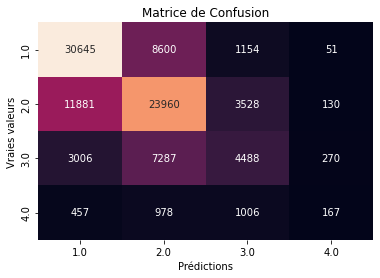

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False,
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()

## Arbre de décision

On utilise le modèle de l'arbre de décision. Le choix des variables finales a été fait par tests successifs du score en rajoutant et enlevant telle et telle variable, en gardant comme noyau dur les variables qui avaient l'air les plus déterminantes dans l'EDA.

Pour l'hyperparamètre `max_depth`, on a également procédé par tests successifs.

On procède également à une imputation des valeurs manquantes simple : on prend
- la moyenne pour les variables catégorielles,
- la modalité la plus fréquente pour les variables catégorielles.

Score maximal obtenu : 0.64.

In [ ]:
numeric_features = ["an_nais", "h", "vma"]
categorical_features = ["agg", "catu", "sexe", "nbv", "trajet", "lum", "col", "manv", "motor", "choc",
                        "catr", "circ", "plan", "situ", "obsm", "ceinture",
                        "casque", "dispositif enfants"]

df_relevant = df_merged[["grav"] + numeric_features + categorical_features]

In [ ]:
from sklearn.impute import SimpleImputer

X = df_relevant.drop("grav", axis=1)
y = df_relevant["grav"]

# On sépare variables numériques et catégorielles
numeric_data = X[numeric_features]
categorical_data = X[categorical_features]

# On impute les NaN pour les numériques
numeric_imputer = SimpleImputer(strategy='mean')
numeric_data_imputed = pd.DataFrame(numeric_imputer.fit_transform(numeric_data), columns=numeric_features)

# On impute les NaN pour les catégorielles
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_data_imputed = pd.DataFrame(categorical_imputer.fit_transform(categorical_data), columns=categorical_features)

# On concatène tout ça dans X
X = pd.concat([numeric_data_imputed, categorical_data_imputed], axis=1)

# On modifie X pour avoir des dummies pour les catégorielles
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
for var in numeric_features:
    X[var] = (X[var]-X[var].mean())/X[var].std()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=14, random_state=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.6403061224489796, 0.6723493192086634)

Voici les scores en cross-validation.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-Validation Scores:", scores)
print(f"Mean Accuracy: {scores.mean():.3f}")

Cross-Validation Scores: [0.64009098 0.64059955 0.63770016 0.64042538 0.63953405]
Mean Accuracy: 0.640


[Text(0.5, 0.9166666666666666, 'ceinture_True <= 0.5\ngini = 0.641\nsamples = 390428\nvalue = [161468, 157885, 60703, 10372]'),
 Text(0.25, 0.75, 'agg_hors agglo <= 0.5\ngini = 0.617\nsamples = 156331\nvalue = [25231, 84019, 40286, 6795]'),
 Text(0.125, 0.5833333333333334, 'catu_piéton <= 0.5\ngini = 0.565\nsamples = 114130\nvalue = [18286, 68803, 24275, 2766]'),
 Text(0.0625, 0.4166666666666667, 'obsm_piéton <= 0.5\ngini = 0.582\nsamples = 85337\nvalue = [17486, 49670, 16463, 1718]'),
 Text(0.03125, 0.25, 'casque_True <= 0.5\ngini = 0.552\nsamples = 78710\nvalue = [12120, 48577, 16310, 1703]'),
 Text(0.015625, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.046875, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.09375, 0.25, 'casque_True <= 0.5\ngini = 0.317\nsamples = 6627\nvalue = [5366, 1093, 153, 15]'),
 Text(0.078125, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.109375, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.1875, 0.4166666666666667, 'an_nais <= -1.353\ngini = 0.483\nsamp

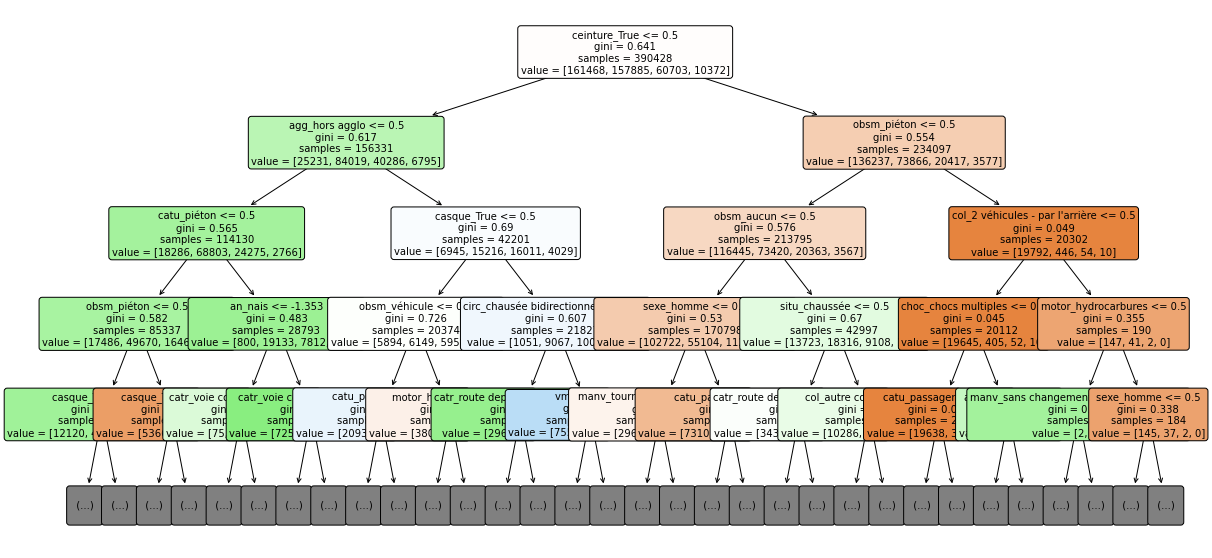

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, max_depth=4, fontsize=10)

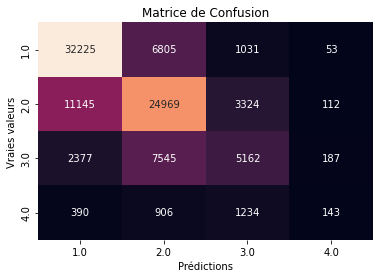

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False,
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()

## Forêt aléatoire

On utilise le modèle de la forêt aléatoire. On a utilisé les mêmes variable que pour l'arbre de décision.

Pour les hyperparamètres `n_estimators` et `max_depth`, on a procédé par tests successifs.

Score maximal obtenu: 0.66.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=30, 
                               max_depth=20, 
                               random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.6593619375461027, 0.7464679787310337)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-Validation Scores:", scores)
print(f"Mean Accuracy: {scores.mean():.3f}")

Cross-Validation Scores: [0.65918777 0.65846712 0.6566947  0.65980923 0.65883594]
Mean Accuracy: 0.659


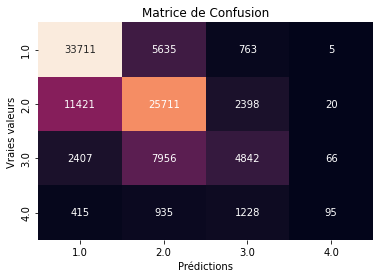

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False,
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()

Comme on a un nombre non négligeable de variables explicatives, il peut être intéressant de compléter notre analyse par une régression Ridge et une régression Lasso : celles-ci nous permettent de gérer de potentiels problèmes de multicollinéarité ou d'overfitting, en régularisant les coefficients (Ridge) ou en les poussant à zéro (Lasso). Pour une évaluation encore plus fiable, on utilise la validation croisée avant chaque régression.

# Conclusion

La régression linéaire a permis de mettre en évidence des variables déterminantes telles que le port de la ceinture, l'utilisation du casque, le statut de piéton, et la conduite d'une moto ou d'un vélo.

Les estimations biaisées des régressions et les scores plafonnants des modèles d'apprentissage machine témoignent du fait qu'un certain nombre de variables pertinentes sont absentes de la base de données. Ainsi, la consommation d'alcool, l'usage de stupéfiants et la vitesse des véhicules apparaissent particulièrement cruciales pour prédire la gravité des accidents, en particulier ceux de nature plus sévère.

Pour les modèles de classification (KNN, arbre de décision, forêt aléatoire), les scores relativement faibles peuvent aussi être expliqués par le fait que la quasi-totalité des variables de la base sont catégorielles, et que les gravités 3 et 4 représentent une faible proportion des cas. 